### AGN population vs redshift

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pynbody as pnb
import os

# Configuration
hdf5_path_template = "/scratch/stlock/tripleAGNs/halomap_files/HaloBH-TangosPynbodyMap-R25-snap{}.hdf5"
sim_path = "/home/stlock/projects/rrg-babul-ad/SHARED/Romulus/cosmo25/"
output_path = "/scratch/stlock/dualAGNs/plots/total_agn_vs_redshift.png"

# Snapshot list (same as in the pipeline)
snapshots = ['000098','000105','000111','000118','000126','000134','000142','000151','000160','000170','000181',
            '000192','000204','000216','000229','000243','000256','000258','000274','000290','000308',
            '000372','000437','000446',
            '000463','000491','000512','000520','000547','000551','000584','000618','000655',
            '000690','000694','000735','000768','000778','000824','000873','000909','000924','000979','001024',
            '001036','001065','001097','001162','001230','001270','001280',
            '001302','001378','001458','001536','001543','001550','001632','001726','001792','001826','001931','001945',
            '002042','002048','002159','002281','002304','002411','002536','002547','002560','002690','002816','002840',
            '002998','003072','003163','003328','003336','003478','003517','003584','003707','003840','003905','004096',
            '004111','004173','004326','004352','004549','004608','004781','004864','005022','005107','005120','005271',
            '005376','005529','005632','005795','005888','006069','006144','006350','006390','006400','006640','006656',
            '006912','006937','007168','007212','007241','007394','007424','007552','007680','007779','007869','007936',
            '008192']

# AGN threshold (same as in build_dualagn_catalog.py)
Lbol_threshold = 1e43  # erg/s
mdot_threshold = 1.89e-3  # Msun/yr

# Constants for Lbol calculation
msun_to_g = 1.989e33
yr_to_s = 3.154e7
c_cgs = 3e10

# Arrays to store results
redshifts = []
agn_counts = []
snapshot_numbers = []

print("Processing snapshots...")

for i, snap in enumerate(snapshots):
    hdf5_file = hdf5_path_template.format(snap)
    sim_file = os.path.join(sim_path, f"cosmo25p.768sg1bwK1BHe75.{snap}")
    
    # Check if files exist
    if not os.path.exists(hdf5_file):
        print(f"Skipping snapshot {snap}: HDF5 file not found")
        continue
    
    if not os.path.exists(sim_file):
        print(f"Skipping snapshot {snap}: simulation file not found")
        continue
    
    try:
        # Load redshift from simulation
        s = pnb.load(sim_file)
        s.physical_units()
        z = s.properties['z']
        
        # Load BH data from halomap
        with h5py.File(hdf5_file, 'r') as hf:
            bh_mdot = np.array(hf['BH_mdot'])
            bh_mass = np.array(hf['BH_mass'])
        
        # Calculate Lbol for all BHs
        Lbol = 0.1 * bh_mdot * msun_to_g / yr_to_s * c_cgs**2
        
        # Count AGNs: BHs with Lbol > 10^43 erg/s
        agn_mask = Lbol > Lbol_threshold
        n_agn = np.sum(agn_mask)
        
        # Store results
        redshifts.append(z)
        agn_counts.append(n_agn)
        snapshot_numbers.append(snap)
        
        print(f"Snapshot {snap} (z={z:.2f}): {n_agn} AGNs found")
        
    except Exception as e:
        print(f"Error processing snapshot {snap}: {e}")
        continue

# Convert to arrays
redshifts = np.array(redshifts)
agn_counts = np.array(agn_counts)

# Sort by redshift (descending, so time goes left to right)
sort_idx = np.argsort(redshifts)[::-1]
redshifts = redshifts[sort_idx]
agn_counts = agn_counts[sort_idx]

print(f"\nTotal snapshots processed: {len(redshifts)}")
print(f"Redshift range: {redshifts.max():.2f} to {redshifts.min():.2f}")
print(f"AGN count range: {agn_counts.min()} to {agn_counts.max()}")

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(redshifts, agn_counts, marker='o', linestyle='-', linewidth=2, 
        markersize=4, color='darkblue', alpha=0.7)

ax.set_xlabel('Redshift', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Number of AGNs', fontsize=14, fontweight='bold')
ax.set_title(r'AGN Population Evolution (L$_{\rm bol}$ > 10$^{43}$ erg/s)', 
             fontsize=16, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='--')
ax.tick_params(labelsize=12)

# Add text box with statistics
textstr = f'Total snapshots: {len(redshifts)}\n'
textstr += f'z range: {redshifts.max():.2f} - {redshifts.min():.2f}\n'
textstr += f'Max AGNs: {agn_counts.max()} at z={redshifts[np.argmax(agn_counts)]:.2f}'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()

# Save figure
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {output_path}")

# Also save data to text file
data_output = output_path.replace('.png', '_data.txt')
with open(data_output, 'w') as f:
    f.write("# Redshift  AGN_Count  Snapshot\n")
    for z, count, snap in zip(redshifts, agn_counts, np.array(snapshot_numbers)[sort_idx]):
        f.write(f"{z:.4f}  {count}  {snap}\n")
print(f"Data saved to: {data_output}")

plt.show()

Processing snapshots...
Skipping snapshot 000098: HDF5 file not found
Skipping snapshot 000105: HDF5 file not found
Skipping snapshot 000111: HDF5 file not found
Skipping snapshot 000118: HDF5 file not found
Skipping snapshot 000126: HDF5 file not found
Skipping snapshot 000134: HDF5 file not found
Skipping snapshot 000142: HDF5 file not found
Skipping snapshot 000151: HDF5 file not found
Skipping snapshot 000160: HDF5 file not found
Skipping snapshot 000170: HDF5 file not found
Skipping snapshot 000181: HDF5 file not found
Skipping snapshot 000192: HDF5 file not found
Skipping snapshot 000204: HDF5 file not found
Skipping snapshot 000216: HDF5 file not found
Skipping snapshot 000229: HDF5 file not found
Skipping snapshot 000243: HDF5 file not found
Skipping snapshot 000256: HDF5 file not found
Skipping snapshot 000258: HDF5 file not found
Skipping snapshot 000274: HDF5 file not found
Skipping snapshot 000290: HDF5 file not found
Skipping snapshot 000308: HDF5 file not found
Skipping s

ValueError: zero-size array to reduction operation maximum which has no identity

### Data validation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.gridspec import GridSpec

# Define paths
catalog_path = "/scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_30kpc_1e43lum/"
output_dir = "/scratch/stlock/tripleAGNs/validation/"
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("VALIDATING TRIPLE AGN CATALOG DATA")
print("="*70)

# Search for catalog files
files_pkl = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog-R50-z*.pkl"))
files_csv = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog-R50-z*.csv"))
files_h5 = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog-R50-z*.h5"))

# Prefer pickle files, then CSV, then HDF5
if files_pkl:
    files_to_read = files_pkl
    file_format = 'pkl'
elif files_csv:
    files_to_read = files_csv
    file_format = 'csv'
elif files_h5:
    files_to_read = files_h5
    file_format = 'h5'
else:
    print("No catalog files found!")
    exit(1)

print(f"Found {len(files_to_read)} catalog files ({file_format} format)\n")

# Storage for all data across redshifts
all_data = []
validation_report = []

# Read each file and validate
for file_path in files_to_read:
    try:
        # Read the file based on format
        if file_format == 'pkl':
            df = pd.read_pickle(file_path)
        elif file_format == 'csv':
            df = pd.read_csv(file_path)
        elif file_format == 'h5':
            df = pd.read_hdf(file_path, key='tripleagn')
        
        if len(df) == 0:
            continue
        
        # Extract redshift from filename
        filename = os.path.basename(file_path)
        z_str = filename.split('-z')[1].split('.')[0] + '.' + filename.split('-z')[1].split('.')[1]
        z = float(z_str)
        
        print(f"\n{'='*70}")
        print(f"REDSHIFT z = {z:.2f} ({len(df)} system(s))")
        print(f"{'='*70}")
        
        file_validation = {
            'redshift': z,
            'num_systems': len(df),
            'issues': []
        }
        
        # Define key columns to check
        bh_columns = {
            'Primary BH': ['BH_id', 'BH_mass', 'BH_mdot', 'BH_Lbol', 'BH_Ledd', 
                          'BH_x', 'BH_y', 'BH_z', 'BH_vx', 'BH_vy', 'BH_vz'],
            'Neighbor 1': ['Neighbour1BH_id', 'Neighbour1BH_mass', 'Neighbour1BH_mdot', 
                          'Neighbour1BH_Lbol', 'Neighbour1BH_Ledd',
                          'Neighbour1BH_x', 'Neighbour1BH_y', 'Neighbour1BH_z'],
            'Neighbor 2': ['Neighbour2BH_id', 'Neighbour2BH_mass', 'Neighbour2BH_mdot', 
                          'Neighbour2BH_Lbol', 'Neighbour2BH_Ledd',
                          'Neighbour2BH_x', 'Neighbour2BH_y', 'Neighbour2BH_z']
        }
        
        # Check column existence
        print("\n1. COLUMN AVAILABILITY CHECK")
        print("-" * 70)
        all_cols_present = True
        for bh_name, cols in bh_columns.items():
            missing = [col for col in cols if col not in df.columns]
            if missing:
                print(f"  {bh_name}: MISSING {len(missing)} columns: {missing}")
                file_validation['issues'].append(f"{bh_name} missing columns: {missing}")
                all_cols_present = False
            else:
                print(f"  {bh_name}: ✓ All columns present")
        
        if all_cols_present:
            print("  >> All expected columns present!")
        
        # Check for NaN/invalid values
        print("\n2. DATA VALIDITY CHECK")
        print("-" * 70)
        
        critical_columns = ['BH_mass', 'BH_mdot', 'BH_Lbol', 
                          'Neighbour1BH_mass', 'Neighbour1BH_mdot', 'Neighbour1BH_Lbol',
                          'Neighbour2BH_mass', 'Neighbour2BH_mdot', 'Neighbour2BH_Lbol']
        
        for col in critical_columns:
            if col in df.columns:
                n_nan = df[col].isna().sum()
                n_inf = np.isinf(df[col]).sum()
                n_zero = (df[col] == 0).sum()
                n_negative = (df[col] < 0).sum()
                
                issues = []
                if n_nan > 0:
                    issues.append(f"{n_nan} NaN")
                if n_inf > 0:
                    issues.append(f"{n_inf} Inf")
                if n_zero > 0:
                    issues.append(f"{n_zero} zeros")
                if n_negative > 0:
                    issues.append(f"{n_negative} negative")
                
                if issues:
                    print(f"  {col}: ⚠ {', '.join(issues)}")
                    file_validation['issues'].append(f"{col}: {', '.join(issues)}")
                else:
                    print(f"  {col}: ✓ All valid")
        
        # Check physical constraints
        print("\n3. PHYSICAL CONSTRAINTS CHECK")
        print("-" * 70)
        
        # AGN luminosity threshold (should all be > 10^43 erg/s)
        lbol_threshold = 1e43
        for bh_label, lbol_col in [('Primary', 'BH_Lbol'), 
                                     ('Neighbor1', 'Neighbour1BH_Lbol'),
                                     ('Neighbor2', 'Neighbour2BH_Lbol')]:
            if lbol_col in df.columns:
                below_threshold = (df[lbol_col] < lbol_threshold).sum()
                if below_threshold > 0:
                    print(f"  {bh_label} Lbol: ⚠ {below_threshold} systems below 10^43 erg/s threshold!")
                    file_validation['issues'].append(f"{bh_label}: {below_threshold} below Lbol threshold")
                else:
                    print(f"  {bh_label} Lbol: ✓ All above 10^43 erg/s")
        
        # Check Eddington ratios
        for bh_label, lbol_col, ledd_col in [('Primary', 'BH_Lbol', 'BH_Ledd'),
                                               ('Neighbor1', 'Neighbour1BH_Lbol', 'Neighbour1BH_Ledd'),
                                               ('Neighbor2', 'Neighbour2BH_Lbol', 'Neighbour2BH_Ledd')]:
            if lbol_col in df.columns and ledd_col in df.columns:
                edd_ratio = df[lbol_col] / df[ledd_col]
                super_edd = (edd_ratio > 1).sum()
                if super_edd > 0:
                    print(f"  {bh_label} Eddington ratio: ⚠ {super_edd} super-Eddington systems")
                    max_ratio = edd_ratio.max()
                    print(f"    Max Lbol/Ledd = {max_ratio:.2f}")
                else:
                    print(f"  {bh_label} Eddington ratio: ✓ All sub-Eddington")
        
        # Check separations
        print("\n4. SEPARATION CONSTRAINTS CHECK")
        print("-" * 70)
        sep_cols = ['Separation_3D_1_kpc', 'Separation_3D_2_kpc', 'Separation_3D_12_kpc']
        for sep_col in sep_cols:
            if sep_col in df.columns:
                min_sep = df[sep_col].min()
                max_sep = df[sep_col].max()
                mean_sep = df[sep_col].mean()
                above_50 = (df[sep_col] > 50).sum()
                
                print(f"  {sep_col}:")
                print(f"    Range: {min_sep:.2f} - {max_sep:.2f} kpc (mean: {mean_sep:.2f})")
                if above_50 > 0:
                    print(f"    ⚠ {above_50} pairs exceed 50 kpc threshold!")
                    file_validation['issues'].append(f"{sep_col}: {above_50} exceed 50 kpc")
        
        # Extract data for all systems at this redshift
        for idx, row in df.iterrows():
            system_data = {
                'redshift': z,
                'system_id': idx,
                
                # Primary BH
                'BH1_mass': row.get('BH_mass', np.nan),
                'BH1_mdot': row.get('BH_mdot', np.nan),
                'BH1_Lbol': row.get('BH_Lbol', np.nan),
                'BH1_Ledd': row.get('BH_Ledd', np.nan),
                'BH1_Lbol_Ledd': row.get('BH_Lbol', np.nan) / row.get('BH_Ledd', 1) if row.get('BH_Ledd', 0) > 0 else np.nan,
                
                # Neighbor 1
                'BH2_mass': row.get('Neighbour1BH_mass', np.nan),
                'BH2_mdot': row.get('Neighbour1BH_mdot', np.nan),
                'BH2_Lbol': row.get('Neighbour1BH_Lbol', np.nan),
                'BH2_Ledd': row.get('Neighbour1BH_Ledd', np.nan),
                'BH2_Lbol_Ledd': row.get('Neighbour1BH_Lbol', np.nan) / row.get('Neighbour1BH_Ledd', 1) if row.get('Neighbour1BH_Ledd', 0) > 0 else np.nan,
                
                # Neighbor 2
                'BH3_mass': row.get('Neighbour2BH_mass', np.nan),
                'BH3_mdot': row.get('Neighbour2BH_mdot', np.nan),
                'BH3_Lbol': row.get('Neighbour2BH_Lbol', np.nan),
                'BH3_Ledd': row.get('Neighbour2BH_Ledd', np.nan),
                'BH3_Lbol_Ledd': row.get('Neighbour2BH_Lbol', np.nan) / row.get('Neighbour2BH_Ledd', 1) if row.get('Neighbour2BH_Ledd', 0) > 0 else np.nan,
                
                # Separations
                'sep_12': row.get('Separation_3D_1_kpc', np.nan),
                'sep_13': row.get('Separation_3D_2_kpc', np.nan),
                'sep_23': row.get('Separation_3D_12_kpc', np.nan),
            }
            all_data.append(system_data)
        
        # Print summary statistics
        print("\n5. SUMMARY STATISTICS")
        print("-" * 70)
        if 'BH_mass' in df.columns:
            print(f"  Primary BH mass range: {df['BH_mass'].min():.2e} - {df['BH_mass'].max():.2e} Msun")
        if 'BH_Lbol' in df.columns:
            print(f"  Primary Lbol range: {df['BH_Lbol'].min():.2e} - {df['BH_Lbol'].max():.2e} erg/s")
        if 'BH_mdot' in df.columns:
            print(f"  Primary mdot range: {df['BH_mdot'].min():.2e} - {df['BH_mdot'].max():.2e} Msun/yr")
        
        validation_report.append(file_validation)
        
    except Exception as e:
        print(f"ERROR reading {os.path.basename(file_path)}: {e}")
        validation_report.append({
            'redshift': 'unknown',
            'num_systems': 0,
            'issues': [f"Failed to read file: {e}"]
        })
        continue

if len(all_data) == 0:
    print("\n\nNo triple AGN systems found in any snapshot!")
    exit(0)

# Convert to DataFrame
data_df = pd.DataFrame(all_data)

# Create comprehensive validation plots
print("\n" + "="*70)
print("CREATING VALIDATION PLOTS")
print("="*70)

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. BH Mass distributions
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist([data_df['BH1_mass'].dropna(), data_df['BH2_mass'].dropna(), data_df['BH3_mass'].dropna()],
         bins=20, label=['Primary', 'Neighbor 1', 'Neighbor 2'], alpha=0.6)
ax1.set_xlabel('BH Mass (Msun)', fontweight='bold')
ax1.set_ylabel('Count', fontweight='bold')
ax1.set_title('BH Mass Distribution', fontweight='bold')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Accretion rate distributions
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist([data_df['BH1_mdot'].dropna(), data_df['BH2_mdot'].dropna(), data_df['BH3_mdot'].dropna()],
         bins=20, label=['Primary', 'Neighbor 1', 'Neighbor 2'], alpha=0.6)
ax2.set_xlabel('Accretion Rate (Msun/yr)', fontweight='bold')
ax2.set_ylabel('Count', fontweight='bold')
ax2.set_title('Accretion Rate Distribution', fontweight='bold')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Luminosity distributions
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist([data_df['BH1_Lbol'].dropna(), data_df['BH2_Lbol'].dropna(), data_df['BH3_Lbol'].dropna()],
         bins=20, label=['Primary', 'Neighbor 1', 'Neighbor 2'], alpha=0.6)
ax3.axvline(1e43, color='r', linestyle='--', linewidth=2, label='AGN threshold')
ax3.set_xlabel('Bolometric Luminosity (erg/s)', fontweight='bold')
ax3.set_ylabel('Count', fontweight='bold')
ax3.set_title('Luminosity Distribution', fontweight='bold')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Eddington ratio distributions
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist([data_df['BH1_Lbol_Ledd'].dropna(), data_df['BH2_Lbol_Ledd'].dropna(), data_df['BH3_Lbol_Ledd'].dropna()],
         bins=20, label=['Primary', 'Neighbor 1', 'Neighbor 2'], alpha=0.6)
ax4.axvline(1.0, color='r', linestyle='--', linewidth=2, label='Eddington limit')
ax4.set_xlabel('Lbol / Ledd', fontweight='bold')
ax4.set_ylabel('Count', fontweight='bold')
ax4.set_title('Eddington Ratio Distribution', fontweight='bold')
ax4.set_xscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Separation distributions
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist([data_df['sep_12'].dropna(), data_df['sep_13'].dropna(), data_df['sep_23'].dropna()],
         bins=20, label=['BH1-BH2', 'BH1-BH3', 'BH2-BH3'], alpha=0.6)
ax5.axvline(50, color='r', linestyle='--', linewidth=2, label='Search radius')
ax5.set_xlabel('Separation (kpc)', fontweight='bold')
ax5.set_ylabel('Count', fontweight='bold')
ax5.set_title('BH Separation Distribution', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Mass vs Luminosity
ax6 = fig.add_subplot(gs[1, 2])
ax6.scatter(data_df['BH1_mass'], data_df['BH1_Lbol'], alpha=0.6, s=50, label='Primary')
ax6.scatter(data_df['BH2_mass'], data_df['BH2_Lbol'], alpha=0.6, s=50, label='Neighbor 1')
ax6.scatter(data_df['BH3_mass'], data_df['BH3_Lbol'], alpha=0.6, s=50, label='Neighbor 2')
ax6.set_xlabel('BH Mass (Msun)', fontweight='bold')
ax6.set_ylabel('Lbol (erg/s)', fontweight='bold')
ax6.set_title('Mass-Luminosity Relation', fontweight='bold')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Mass vs Accretion rate
ax7 = fig.add_subplot(gs[2, 0])
ax7.scatter(data_df['BH1_mass'], data_df['BH1_mdot'], alpha=0.6, s=50, label='Primary')
ax7.scatter(data_df['BH2_mass'], data_df['BH2_mdot'], alpha=0.6, s=50, label='Neighbor 1')
ax7.scatter(data_df['BH3_mass'], data_df['BH3_mdot'], alpha=0.6, s=50, label='Neighbor 2')
ax7.set_xlabel('BH Mass (Msun)', fontweight='bold')
ax7.set_ylabel('Accretion Rate (Msun/yr)', fontweight='bold')
ax7.set_title('Mass-Accretion Rate Relation', fontweight='bold')
ax7.set_xscale('log')
ax7.set_yscale('log')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Properties vs redshift
ax8 = fig.add_subplot(gs[2, 1])
ax8.scatter(data_df['redshift'], data_df['BH1_mass'], alpha=0.4, s=30, label='BH1 mass')
ax8.scatter(data_df['redshift'], data_df['BH2_mass'], alpha=0.4, s=30, label='BH2 mass')
ax8.scatter(data_df['redshift'], data_df['BH3_mass'], alpha=0.4, s=30, label='BH3 mass')
ax8.set_xlabel('Redshift', fontweight='bold')
ax8.set_ylabel('BH Mass (Msun)', fontweight='bold')
ax8.set_title('BH Mass vs Redshift', fontweight='bold')
ax8.set_yscale('log')
ax8.invert_xaxis()
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Separation vs redshift
ax9 = fig.add_subplot(gs[2, 2])
ax9.scatter(data_df['redshift'], data_df['sep_12'], alpha=0.4, s=30, label='BH1-BH2')
ax9.scatter(data_df['redshift'], data_df['sep_13'], alpha=0.4, s=30, label='BH1-BH3')
ax9.scatter(data_df['redshift'], data_df['sep_23'], alpha=0.4, s=30, label='BH2-BH3')
ax9.axhline(50, color='r', linestyle='--', linewidth=2, alpha=0.5)
ax9.set_xlabel('Redshift', fontweight='bold')
ax9.set_ylabel('Separation (kpc)', fontweight='bold')
ax9.set_title('Separations vs Redshift', fontweight='bold')
ax9.invert_xaxis()
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.suptitle('Triple AGN System Data Validation', fontsize=18, fontweight='bold', y=0.995)

plot_path = os.path.join(output_dir, "triple_agn_data_validation.png")
#plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Validation plot saved to: {plot_path}")

# Save data summary
summary_path = os.path.join(output_dir, "data_validation_summary.txt")
with open(summary_path, 'w') as f:
    f.write("TRIPLE AGN DATA VALIDATION SUMMARY\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Total systems analyzed: {len(data_df)}\n")
    f.write(f"Redshift range: {data_df['redshift'].min():.2f} - {data_df['redshift'].max():.2f}\n\n")
    
    f.write("PRIMARY BH STATISTICS:\n")
    f.write(f"  Mass: {data_df['BH1_mass'].min():.2e} - {data_df['BH1_mass'].max():.2e} Msun (median: {data_df['BH1_mass'].median():.2e})\n")
    f.write(f"  Mdot: {data_df['BH1_mdot'].min():.2e} - {data_df['BH1_mdot'].max():.2e} Msun/yr (median: {data_df['BH1_mdot'].median():.2e})\n")
    f.write(f"  Lbol: {data_df['BH1_Lbol'].min():.2e} - {data_df['BH1_Lbol'].max():.2e} erg/s (median: {data_df['BH1_Lbol'].median():.2e})\n")
    f.write(f"  Lbol/Ledd: {data_df['BH1_Lbol_Ledd'].min():.3f} - {data_df['BH1_Lbol_Ledd'].max():.3f} (median: {data_df['BH1_Lbol_Ledd'].median():.3f})\n\n")
    
    f.write("SEPARATIONS:\n")
    f.write(f"  BH1-BH2: {data_df['sep_12'].min():.2f} - {data_df['sep_12'].max():.2f} kpc (mean: {data_df['sep_12'].mean():.2f})\n")
    f.write(f"  BH1-BH3: {data_df['sep_13'].min():.2f} - {data_df['sep_13'].max():.2f} kpc (mean: {data_df['sep_13'].mean():.2f})\n")
    f.write(f"  BH2-BH3: {data_df['sep_23'].min():.2f} - {data_df['sep_23'].max():.2f} kpc (mean: {data_df['sep_23'].mean():.2f})\n\n")
    
    f.write("DATA QUALITY ISSUES BY REDSHIFT:\n")
    for report in validation_report:
        if report['num_systems'] > 0:
            f.write(f"\nz = {report['redshift']:.2f} ({report['num_systems']} system(s)):\n")
            if report['issues']:
                for issue in report['issues']:
                    f.write(f"  - {issue}\n")
            else:
                f.write("  ✓ No issues detected\n")

print(f"Summary saved to: {summary_path}")

# Save detailed data
#data_path = os.path.join(output_dir, "triple_agn_validated_data.csv")
#data_df.to_csv(data_path, index=False)
#print(f"Detailed data saved to: {data_path}")

print("\n" + "="*70)
print("VALIDATION COMPLETE")
print("="*70)
print(f"Total systems validated: {len(data_df)}")
print(f"Files with issues: {sum(1 for r in validation_report if r['issues'])}")
print(f"All data appears valid: {'YES' if all(not r['issues'] for r in validation_report) else 'NO'}")

### Population vs redshift

COMPARING TRIPLE AGN RUNS WITH DIFFERENT PARAMETERS

READING Lbol > 1e43 erg/s RUNS

Reading catalogs for: 30 kpc
  Path: /scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_30kpc_1e43lum/
  Found 60 files (pkl format)
  Successfully read 60 snapshots
  Redshift range: 0.06 - 3.00
  Total triple systems: 68

Reading catalogs for: 50 kpc
  Path: /scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_50kpc_1e43lum/
  Found 60 files (pkl format)
  Successfully read 60 snapshots
  Redshift range: 0.06 - 3.00
  Total triple systems: 73

Reading catalogs for: 100 kpc
  Path: /scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_100kpc_1e43lum/
  Found 60 files (pkl format)
  Successfully read 60 snapshots
  Redshift range: 0.06 - 3.00
  Total triple systems: 82

READING Lbol > 1e40 erg/s RUNS

Reading catalogs for: 30 kpc
  Path: /scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_30kpc_1e40lum/
  Found 60 files (pkl format)
  Successfully read 60 snapshots
  Redshift range: 0.06 - 3.00
 

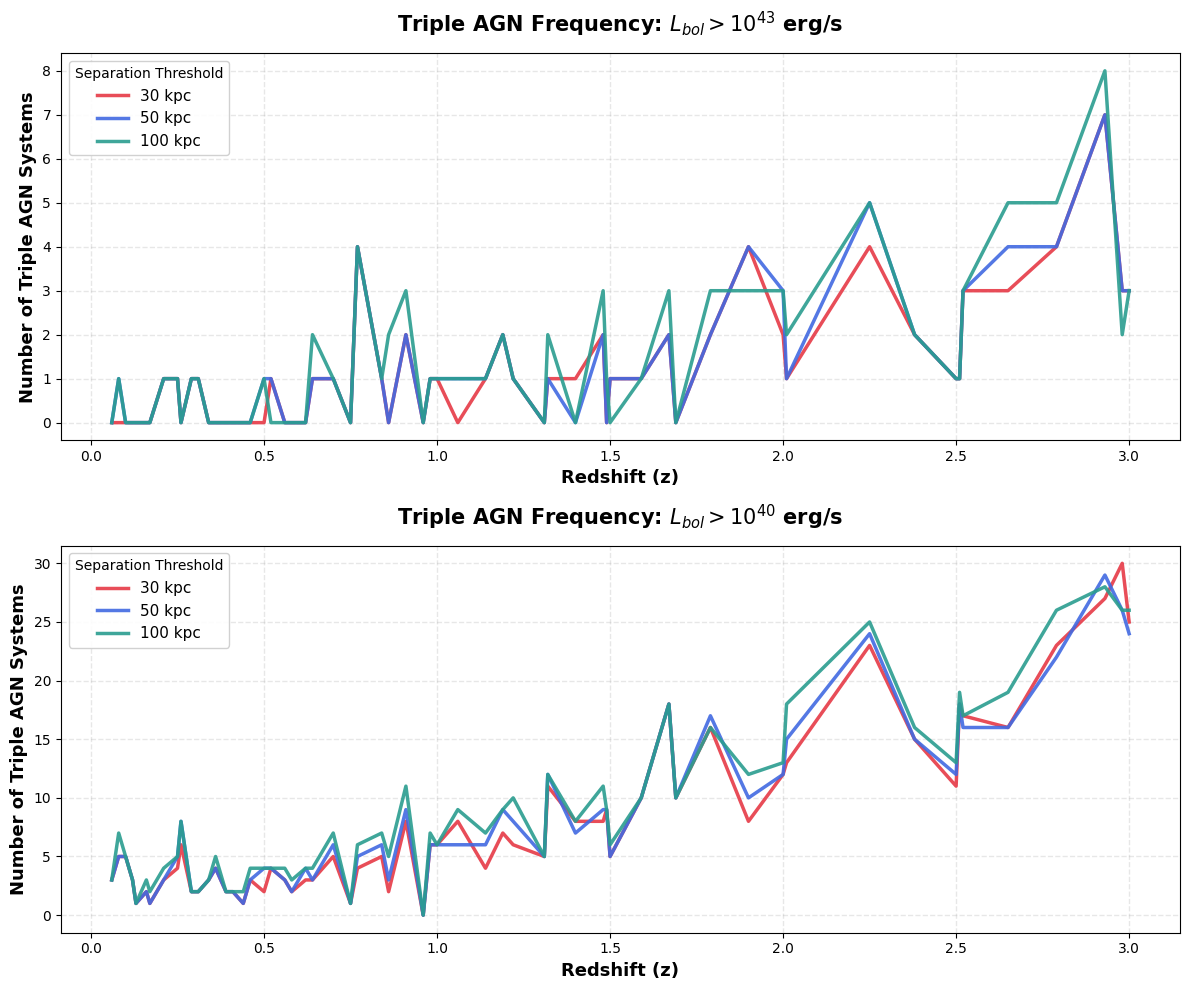

Summary saved to: /scratch/stlock/tripleAGNs/comparison_plots/parameter_comparison_summary.txt

COMPARISON COMPLETE


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

##############################################
# CONFIGURATION - EDIT THESE PATHS
##############################################

# Dictionary structure: {run_name: catalog_path}
# Runs with Lbol > 1e43 erg/s
runs_1e43 = {
    '30 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_30kpc_1e43lum/",
    '50 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_50kpc_1e43lum/",
    '100 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_100kpc_1e43lum/"
}

# Runs with Lbol > 1e40 erg/s
runs_1e40 = {
    '30 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_30kpc_1e40lum/",
    '50 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_50kpc_1e40lum/",
    '100 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_100kpc_1e40lum/"
}


# Output directory
output_dir = "/scratch/stlock/tripleAGNs/comparison_plots/"
os.makedirs(output_dir, exist_ok=True)

##############################################
# FUNCTIONS
##############################################

def read_catalogs(catalog_path, run_name):
    """Read all catalog files from a given path and return redshifts and counts."""
    
    print(f"\nReading catalogs for: {run_name}")
    print(f"  Path: {catalog_path}")
    
    # Search for files in different formats
    files_pkl = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.pkl"))
    files_csv = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.csv"))
    files_h5 = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.h5"))
    
    # Prefer pickle files, then CSV, then HDF5
    if files_pkl:
        files_to_read = files_pkl
        file_format = 'pkl'
    elif files_csv:
        files_to_read = files_csv
        file_format = 'csv'
    elif files_h5:
        files_to_read = files_h5
        file_format = 'h5'
    else:
        print(f"  WARNING: No catalog files found!")
        return np.array([]), np.array([])
    
    print(f"  Found {len(files_to_read)} files ({file_format} format)")
    
    redshifts = []
    triple_counts = []
    
    # Read each file
    for file_path in files_to_read:
        try:
            # Read the file based on format
            if file_format == 'pkl':
                df = pd.read_pickle(file_path)
            elif file_format == 'csv':
                df = pd.read_csv(file_path)
            elif file_format == 'h5':
                df = pd.read_hdf(file_path, key='tripleagn')
            
            # Extract redshift from filename
            filename = os.path.basename(file_path)
            
            # Handle different filename formats
            if '-z' in filename:
                z_str = filename.split('-z')[1].split('.')[0] + '.' + filename.split('-z')[1].split('.')[1]
            elif '_z' in filename:
                z_str = filename.split('_z')[1].split('.')[0] + '.' + filename.split('_z')[1].split('.')[1]
            else:
                print(f"  WARNING: Cannot parse redshift from {filename}")
                continue
            
            z = float(z_str)
            
            # Count triple systems
            num_triples = len(df)
            
            redshifts.append(z)
            triple_counts.append(num_triples)
            
        except Exception as e:
            print(f"  ERROR reading {os.path.basename(file_path)}: {e}")
            continue
    
    if len(redshifts) == 0:
        print(f"  WARNING: No data successfully read!")
        return np.array([]), np.array([])
    
    # Sort by redshift
    sort_idx = np.argsort(redshifts)
    redshifts = np.array(redshifts)[sort_idx]
    triple_counts = np.array(triple_counts)[sort_idx]
    
    print(f"  Successfully read {len(redshifts)} snapshots")
    print(f"  Redshift range: {redshifts.min():.2f} - {redshifts.max():.2f}")
    print(f"  Total triple systems: {triple_counts.sum()}")
    
    return redshifts, triple_counts

##############################################
# MAIN EXECUTION
##############################################

print("="*70)
print("COMPARING TRIPLE AGN RUNS WITH DIFFERENT PARAMETERS")
print("="*70)

# Read data for all runs
data_1e43 = {}
data_1e40 = {}

print("\n" + "="*70)
print("READING Lbol > 1e43 erg/s RUNS")
print("="*70)

for run_name, catalog_path in runs_1e43.items():
    redshifts, counts = read_catalogs(catalog_path, run_name)
    if len(redshifts) > 0:
        data_1e43[run_name] = {'redshifts': redshifts, 'counts': counts}

print("\n" + "="*70)
print("READING Lbol > 1e40 erg/s RUNS")
print("="*70)

for run_name, catalog_path in runs_1e40.items():
    redshifts, counts = read_catalogs(catalog_path, run_name)
    if len(redshifts) > 0:
        data_1e40[run_name] = {'redshifts': redshifts, 'counts': counts}

# Check if we have data
if len(data_1e43) == 0 and len(data_1e40) == 0:
    print("\nERROR: No data found for any run!")
    exit(1)

##############################################
# PLOTTING
##############################################

print("\n" + "="*70)
print("CREATING COMPARISON PLOTS")
print("="*70)

# Define colors and markers for each separation threshold
colors = {'30 kpc': '#E63946', '50 kpc': '#4169E1', '100 kpc': '#2A9D8F'}
markers = {'30 kpc': 'o', '50 kpc': 's', '100 kpc': '^'}
linestyles = {'30 kpc': '-', '50 kpc': '-', '100 kpc': '-'}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

##############################################
# PLOT 1: Lbol > 1e43 erg/s
##############################################

if len(data_1e43) > 0:
    for run_name, data in data_1e43.items():
        redshifts = data['redshifts']
        counts = data['counts']
        
        # Plot line only
        ax1.plot(redshifts, counts, 
                linestyle=linestyles.get(run_name, '-'),
                linewidth=2.5, 
                color=colors.get(run_name, 'black'),
                alpha=0.9,
                label=f'{run_name}',
                zorder=2)
    
    ax1.set_xlabel('Redshift (z)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Number of Triple AGN Systems', fontsize=13, fontweight='bold')
    ax1.set_title('Triple AGN Frequency: $L_{bol} > 10^{43}$ erg/s', 
                  fontsize=15, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, linestyle='--', linewidth=1)
    ax1.legend(fontsize=11, loc='best', framealpha=0.9, title='Separation Threshold')
    #ax1.set_xlim(bottom=-0.5)
else:
    ax1.text(0.5, 0.5, 'No data available for Lbol > 1e43 erg/s runs',
            ha='center', va='center', transform=ax1.transAxes, fontsize=14)
    ax1.set_xlabel('Redshift (z)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Number of Triple AGN Systems', fontsize=13, fontweight='bold')
    ax1.set_title('Triple AGN Frequency: $L_{bol} > 10^{43}$ erg/s', 
                  fontsize=15, fontweight='bold', pad=15)

##############################################
# PLOT 2: Lbol > 1e40 erg/s
##############################################

if len(data_1e40) > 0:
    for run_name, data in data_1e40.items():
        redshifts = data['redshifts']
        counts = data['counts']
        
        # Plot line only
        ax2.plot(redshifts, counts, 
                linestyle=linestyles.get(run_name, '-'),
                linewidth=2.5, 
                color=colors.get(run_name, 'black'),
                alpha=0.9,
                label=f'{run_name}',
                zorder=2)
    
    ax2.set_xlabel('Redshift (z)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Number of Triple AGN Systems', fontsize=13, fontweight='bold')
    ax2.set_title('Triple AGN Frequency: $L_{bol} > 10^{40}$ erg/s', 
                  fontsize=15, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3, linestyle='--', linewidth=1)
    ax2.legend(fontsize=11, loc='best', framealpha=0.9, title='Separation Threshold')
    #ax1.set_xlim(bottom=-0.5)
else:
    ax2.text(0.5, 0.5, 'No data available for Lbol > 1e40 erg/s runs',
            ha='center', va='center', transform=ax2.transAxes, fontsize=14)
    ax2.set_xlabel('Redshift (z)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Number of Triple AGN Systems', fontsize=13, fontweight='bold')
    ax2.set_title('Triple AGN Frequency: $L_{bol} > 10^{40}$ erg/s', 
                  fontsize=15, fontweight='bold', pad=15)

plt.tight_layout()

# Save figure
plot_path = os.path.join(output_dir, "triple_agn_parameter_comparison.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\nComparison plot saved to: {plot_path}")

# Also save PDF
pdf_path = plot_path.replace('.png', '.pdf')
plt.savefig(pdf_path, bbox_inches='tight')
print(f"PDF saved to: {pdf_path}")

plt.show()

##############################################
# SAVE SUMMARY STATISTICS
##############################################

summary_path = os.path.join(output_dir, "parameter_comparison_summary.txt")
with open(summary_path, 'w') as f:
    f.write("TRIPLE AGN PARAMETER COMPARISON SUMMARY\n")
    f.write("="*70 + "\n\n")
    
    f.write("Lbol > 1e43 erg/s RUNS:\n")
    f.write("-"*70 + "\n")
    if len(data_1e43) > 0:
        for run_name, data in data_1e43.items():
            f.write(f"\n{run_name}:\n")
            f.write(f"  Total systems: {data['counts'].sum()}\n")
            f.write(f"  Snapshots with systems: {(data['counts'] > 0).sum()}\n")
            f.write(f"  Max systems in one snapshot: {data['counts'].max()}\n")
            if data['counts'].sum() > 0:
                max_idx = np.argmax(data['counts'])
                f.write(f"    (at z = {data['redshifts'][max_idx]:.2f})\n")
            f.write(f"  Detection rate: {100 * (data['counts'] > 0).sum() / len(data['counts']):.1f}%\n")
    else:
        f.write("  No data available\n")
    
    f.write("\n\nLbol > 1e40 erg/s RUNS:\n")
    f.write("-"*70 + "\n")
    if len(data_1e40) > 0:
        for run_name, data in data_1e40.items():
            f.write(f"\n{run_name}:\n")
            f.write(f"  Total systems: {data['counts'].sum()}\n")
            f.write(f"  Snapshots with systems: {(data['counts'] > 0).sum()}\n")
            f.write(f"  Max systems in one snapshot: {data['counts'].max()}\n")
            if data['counts'].sum() > 0:
                max_idx = np.argmax(data['counts'])
                f.write(f"    (at z = {data['redshifts'][max_idx]:.2f})\n")
            f.write(f"  Detection rate: {100 * (data['counts'] > 0).sum() / len(data['counts']):.1f}%\n")
    else:
        f.write("  No data available\n")
    
    # Comparison section
    f.write("\n\nCOMPARISON INSIGHTS:\n")
    f.write("-"*70 + "\n")
    
    if len(data_1e43) > 0:
        total_1e43 = {name: data['counts'].sum() for name, data in data_1e43.items()}
        f.write(f"\nEffect of separation threshold (Lbol > 1e43):\n")
        for name in sorted(total_1e43.keys()):
            f.write(f"  {name}: {total_1e43[name]} systems\n")
    
    if len(data_1e40) > 0:
        total_1e40 = {name: data['counts'].sum() for name, data in data_1e40.items()}
        f.write(f"\nEffect of separation threshold (Lbol > 1e40):\n")
        for name in sorted(total_1e40.keys()):
            f.write(f"  {name}: {total_1e40[name]} systems\n")
    
    if len(data_1e43) > 0 and len(data_1e40) > 0:
        f.write(f"\nEffect of luminosity threshold:\n")
        for name in runs_1e43.keys():
            if name in data_1e43 and name in data_1e40:
                count_1e43 = data_1e43[name]['counts'].sum()
                count_1e40 = data_1e40[name]['counts'].sum()
                ratio = count_1e40 / count_1e43 if count_1e43 > 0 else np.inf
                f.write(f"  {name}: {count_1e40}/{count_1e43} = {ratio:.1f}x more systems with lower threshold\n")

print(f"Summary saved to: {summary_path}")

print("\n" + "="*70)
print("COMPARISON COMPLETE")
print("="*70)

### Seperations vs redshift

ANALYZING TRIPLE AGN SEPARATIONS
Found 60 catalog files (pkl format)



/tmp/ipykernel_2718219/3822042883.py:77: RuntimeWarning: All-NaN axis encountered
  'min_separation': np.nanmin([sep_12, sep_13, sep_23]),
/tmp/ipykernel_2718219/3822042883.py:78: RuntimeWarning: All-NaN axis encountered
  'max_separation': np.nanmax([sep_12, sep_13, sep_23]),
/tmp/ipykernel_2718219/3822042883.py:79: RuntimeWarning: Mean of empty slice
  'mean_separation': np.nanmean([sep_12, sep_13, sep_23]),
/tmp/ipykernel_2718219/3822042883.py:80: RuntimeWarning: All-NaN axis encountered
  'separation_ratio': np.nanmax([sep_12, sep_13, sep_23]) / np.nanmin([sep_12, sep_13, sep_23]),
/tmp/ipykernel_2718219/3822042883.py:77: RuntimeWarning: All-NaN axis encountered
  'min_separation': np.nanmin([sep_12, sep_13, sep_23]),
/tmp/ipykernel_2718219/3822042883.py:78: RuntimeWarning: All-NaN axis encountered
  'max_separation': np.nanmax([sep_12, sep_13, sep_23]),
/tmp/ipykernel_2718219/3822042883.py:79: RuntimeWarning: Mean of empty slice
  'mean_separation': np.nanmean([sep_12, sep_13, sep

z=0.06: 3 system(s)
z=0.08: 4 system(s)
z=0.10: 5 system(s)
z=0.12: 2 system(s)
z=0.16: 1 system(s)
z=0.17: 1 system(s)
z=0.21: 2 system(s)
z=0.25: 2 system(s)
z=0.26: 4 system(s)
z=0.29: 2 system(s)
z=0.31: 1 system(s)
z=0.34: 3 system(s)
z=0.36: 3 system(s)
z=0.39: 2 system(s)
z=0.41: 2 system(s)
z=0.44: 1 system(s)
z=0.46: 2 system(s)
z=0.52: 2 system(s)
z=0.56: 1 system(s)
z=0.58: 1 system(s)
z=0.62: 1 system(s)
z=0.64: 2 system(s)
z=0.70: 4 system(s)
z=0.77: 5 system(s)
z=0.84: 4 system(s)
z=0.86: 1 system(s)
z=0.91: 5 system(s)
z=0.98: 3 system(s)
z=1.00: 4 system(s)
z=1.06: 4 system(s)
z=1.14: 2 system(s)
z=1.19: 6 system(s)
z=1.22: 4 system(s)
z=1.31: 2 system(s)
z=1.32: 6 system(s)
z=1.40: 5 system(s)
z=1.48: 6 system(s)
z=1.49: 7 system(s)
z=1.50: 3 system(s)
z=1.59: 11 system(s)
z=1.67: 16 system(s)
z=1.69: 9 system(s)
z=1.79: 10 system(s)
z=1.90: 6 system(s)
z=2.00: 9 system(s)
z=2.01: 9 system(s)
z=2.25: 20 system(s)
z=2.38: 14 system(s)
z=2.50: 11 system(s)
z=2.51: 13 sys

/tmp/ipykernel_2718219/3822042883.py:157: RuntimeWarning: Mean of empty slice.
  ax1.axvline(all_seps.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_seps.mean():.1f} kpc')
/home/stlock/.venvs/romulus_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Plot saved to: /scratch/stlock/tripleAGNs/plots_and_data/triple_agn_separations.png
Separation data saved to: /scratch/stlock/tripleAGNs/plots_and_data/separation_data.csv

TOP 10 BEST CANDIDATE SYSTEMS FOR STUDY
(Based on: compact, bright, low redshift)



'\nfor i, (idx, row) in enumerate(top_10.iterrows(), 1):\n    print(f"{i}. z={row[\'redshift\']:.2f}, Mean sep={row[\'mean_separation\']:.2f} kpc")\n    print(f"   BH IDs: {row[\'BH1_id\']:.0f}, {row[\'BH2_id\']:.0f}, {row[\'BH3_id\']:.0f}")\n    print(f"   Halo: {row[\'halo_id\']:.0f}, Mass: {row[\'halo_mass\']:.2e} Msun" if not pd.isna(row[\'halo_mass\']) else "   Halo: N/A")\n    print(f"   Total Lbol: {(row[\'BH1_Lbol\'] + row[\'BH2_Lbol\'] + row[\'BH3_Lbol\']):.2e} erg/s")\n    print(f"   Separations: {row[\'sep_BH1_BH2\']:.1f}, {row[\'sep_BH1_BH3\']:.1f}, {row[\'sep_BH2_BH3\']:.1f} kpc\n")\n\nbest_candidates_path = os.path.join(output_dir, "best_candidate_systems.csv")\ntop_10.to_csv(best_candidates_path, index=False)\nprint(f"Best candidates saved to: {best_candidates_path}")\n\nprint("\n" + "="*70)\nprint("ANALYSIS COMPLETE")\nprint("="*70)\n'

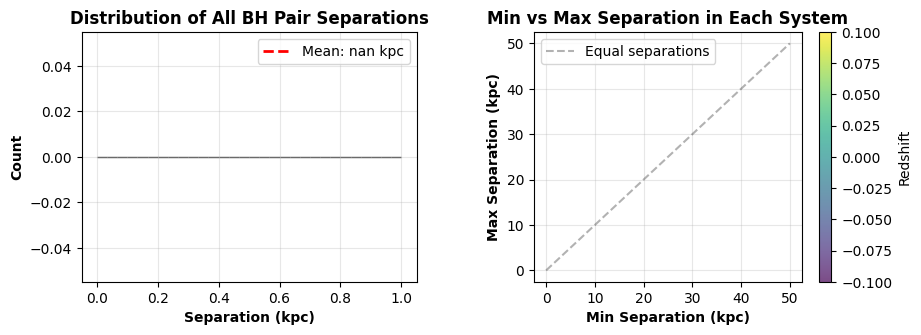

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.gridspec import GridSpec

# Define paths
catalog_path = "/scratch/stlock/tripleAGNs/catalogs/1e41lum/catalogue_15kpc_1e41lum/"  # Adjust as needed
output_dir = "/scratch/stlock/tripleAGNs/plots_and_data/"
os.makedirs(output_dir, exist_ok=True)



print("="*70)
print("ANALYZING TRIPLE AGN SEPARATIONS")
print("="*70)

# Search for catalog files
files_pkl = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.pkl"))
files_csv = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.csv"))
files_h5 = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.h5"))

# Prefer pickle files, then CSV, then HDF5
if files_pkl:
    files_to_read = files_pkl
    file_format = 'pkl'
elif files_csv:
    files_to_read = files_csv
    file_format = 'csv'
elif files_h5:
    files_to_read = files_h5
    file_format = 'h5'
else:
    print("No catalog files found!")
    exit(1)

print(f"Found {len(files_to_read)} catalog files ({file_format} format)\n")

# Storage for all systems
all_systems = []

# Read each file
for file_path in files_to_read:
    try:
        # Read the file based on format
        if file_format == 'pkl':
            df = pd.read_pickle(file_path)
        elif file_format == 'csv':
            df = pd.read_csv(file_path)
        elif file_format == 'h5':
            df = pd.read_hdf(file_path, key='tripleagn')
        
        if len(df) == 0:
            continue
        
        # Extract redshift from filename
        filename = os.path.basename(file_path)
        if '-z' in filename:
            z_str = filename.split('-z')[1].split('.')[0] + '.' + filename.split('-z')[1].split('.')[1]
        else:
            z_str = filename.split('_z')[1].split('.')[0] + '.' + filename.split('_z')[1].split('.')[1]
        z = float(z_str)
        
        # Extract separation data for each system
        for idx, row in df.iterrows():
            sep_12 = row.get('Separation_3D_1_kpc', np.nan)
            sep_13 = row.get('Separation_3D_2_kpc', np.nan)
            sep_23 = row.get('Separation_3D_12_kpc', np.nan)
            
            system_data = {
                'redshift': z,
                'system_id': idx,
                'sep_BH1_BH2': sep_12,
                'sep_BH1_BH3': sep_13,
                'sep_BH2_BH3': sep_23,
                'min_separation': np.nanmin([sep_12, sep_13, sep_23]),
                'max_separation': np.nanmax([sep_12, sep_13, sep_23]),
                'mean_separation': np.nanmean([sep_12, sep_13, sep_23]),
                'separation_ratio': np.nanmax([sep_12, sep_13, sep_23]) / np.nanmin([sep_12, sep_13, sep_23]),
                
                # BH masses for context
                'BH1_mass': row.get('BH_mass', np.nan),
                'BH2_mass': row.get('Neighbour1BH_mass', np.nan),
                'BH3_mass': row.get('Neighbour2BH_mass', np.nan),
                
                # BH luminosities
                'BH1_Lbol': row.get('BH_Lbol', np.nan),
                'BH2_Lbol': row.get('Neighbour1BH_Lbol', np.nan),
                'BH3_Lbol': row.get('Neighbour2BH_Lbol', np.nan),
                
                # BH IDs for tracking
                'BH1_id': row.get('BH_id', np.nan),
                'BH2_id': row.get('Neighbour1BH_id', np.nan),
                'BH3_id': row.get('Neighbour2BH_id', np.nan),
                
                # Halo info
                'halo_id': row.get('pynbody_haloid', np.nan),
                'halo_mass': row.get('Halo_Mvir', np.nan),
            }
            
            all_systems.append(system_data)
        
        print(f"z={z:.2f}: {len(df)} system(s)")
        
    except Exception as e:
        print(f"ERROR reading {os.path.basename(file_path)}: {e}")
        continue

if len(all_systems) == 0:
    print("No triple AGN systems found!")
    exit(0)

# Convert to DataFrame
systems_df = pd.DataFrame(all_systems)

print(f"\nTotal systems analyzed: {len(systems_df)}")

# Print statistics
print("\n" + "="*70)
print("SEPARATION STATISTICS")
print("="*70)
print(f"\nMinimum separations (closest BH pair in each system):")
print(f"  Range: {systems_df['min_separation'].min():.2f} - {systems_df['min_separation'].max():.2f} kpc")
print(f"  Mean: {systems_df['min_separation'].mean():.2f} ± {systems_df['min_separation'].std():.2f} kpc")
print(f"  Median: {systems_df['min_separation'].median():.2f} kpc")

print(f"\nMaximum separations (farthest BH pair in each system):")
print(f"  Range: {systems_df['max_separation'].min():.2f} - {systems_df['max_separation'].max():.2f} kpc")
print(f"  Mean: {systems_df['max_separation'].mean():.2f} ± {systems_df['max_separation'].std():.2f} kpc")
print(f"  Median: {systems_df['max_separation'].median():.2f} kpc")

print(f"\nSeparation ratio (max/min in each system):")
print(f"  Range: {systems_df['separation_ratio'].min():.2f} - {systems_df['separation_ratio'].max():.2f}")
print(f"  Mean: {systems_df['separation_ratio'].mean():.2f} ± {systems_df['separation_ratio'].std():.2f}")
print(f"  Median: {systems_df['separation_ratio'].median():.2f}")

# Identify compact vs extended systems
compact_systems = systems_df[systems_df['max_separation'] < 20]
extended_systems = systems_df[systems_df['max_separation'] > 30]
print(f"\nCompact systems (max sep < 20 kpc): {len(compact_systems)} ({100*len(compact_systems)/len(systems_df):.1f}%)")
print(f"Extended systems (max sep > 30 kpc): {len(extended_systems)} ({100*len(extended_systems)/len(systems_df):.1f}%)")

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.35)

# Plot 1: Distribution of all separations
ax1 = fig.add_subplot(gs[0, 0])
all_seps = np.concatenate([systems_df['sep_BH1_BH2'].dropna(), 
                           systems_df['sep_BH1_BH3'].dropna(), 
                           systems_df['sep_BH2_BH3'].dropna()])
ax1.hist(all_seps, bins=30, color='#4169E1', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Separation (kpc)', fontweight='bold')
ax1.set_ylabel('Count', fontweight='bold')
ax1.set_title('Distribution of All BH Pair Separations', fontweight='bold')
ax1.axvline(all_seps.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_seps.mean():.1f} kpc')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Min vs Max separation
ax2 = fig.add_subplot(gs[0, 1])
scatter = ax2.scatter(systems_df['min_separation'], systems_df['max_separation'], 
                     c=systems_df['redshift'], cmap='viridis', s=60, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.plot([0, 50], [0, 50], 'k--', alpha=0.3, label='Equal separations')
ax2.set_xlabel('Min Separation (kpc)', fontweight='bold')
ax2.set_ylabel('Max Separation (kpc)', fontweight='bold')
ax2.set_title('Min vs Max Separation in Each System', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Redshift')
"""
# Plot 3: Separation ratio distribution
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(systems_df['separation_ratio'], bins=20, color='#2A9D8F', alpha=0.7, edgecolor='black')
ax3.axvline(1, color='red', linestyle='--', linewidth=2, label='Equilateral (ratio=1)')
ax3.set_xlabel('Separation Ratio (max/min)', fontweight='bold')
ax3.set_ylabel('Count', fontweight='bold')
ax3.set_title('Configuration: Compact vs Extended', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Separations vs redshift
ax4 = fig.add_subplot(gs[1, 0])
ax4.scatter(systems_df['redshift'], systems_df['min_separation'], 
           alpha=0.5, s=40, label='Min separation', color='#E63946')
ax4.scatter(systems_df['redshift'], systems_df['max_separation'], 
           alpha=0.5, s=40, label='Max separation', color='#4169E1')
ax4.set_xlabel('Redshift', fontweight='bold')
ax4.set_ylabel('Separation (kpc)', fontweight='bold')
ax4.set_title('Separations vs Redshift', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Mean separation vs halo mass
ax5 = fig.add_subplot(gs[1, 1])
valid_mass = systems_df[systems_df['halo_mass'].notna()]
if len(valid_mass) > 0:
    scatter = ax5.scatter(valid_mass['halo_mass'], valid_mass['mean_separation'],
                         c=valid_mass['redshift'], cmap='viridis', s=60, alpha=0.7, 
                         edgecolor='black', linewidth=0.5)
    ax5.set_xlabel('Halo Mass (Msun)', fontweight='bold')
    ax5.set_ylabel('Mean Separation (kpc)', fontweight='bold')
    ax5.set_title('Separation vs Halo Mass', fontweight='bold')
    ax5.set_xscale('log')
    ax5.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax5, label='Redshift')
else:
    ax5.text(0.5, 0.5, 'No halo mass data available', ha='center', va='center', 
            transform=ax5.transAxes, fontsize=12)

# Plot 6: 2D histogram of BH pair separations
ax6 = fig.add_subplot(gs[1, 2])
h = ax6.hist2d(systems_df['sep_BH1_BH2'].dropna(), systems_df['sep_BH1_BH3'].dropna(),
               bins=20, cmap='YlOrRd', cmin=1)
ax6.set_xlabel('BH1-BH2 Separation (kpc)', fontweight='bold')
ax6.set_ylabel('BH1-BH3 Separation (kpc)', fontweight='bold')
ax6.set_title('Joint Distribution of Separations', fontweight='bold')
plt.colorbar(h[3], ax=ax6, label='Count')

# Plot 7: Individual pair separations
ax7 = fig.add_subplot(gs[2, 0])
ax7.hist([systems_df['sep_BH1_BH2'].dropna(), 
          systems_df['sep_BH1_BH3'].dropna(),
          systems_df['sep_BH2_BH3'].dropna()],
         bins=20, label=['BH1-BH2', 'BH1-BH3', 'BH2-BH3'], alpha=0.6)
ax7.set_xlabel('Separation (kpc)', fontweight='bold')
ax7.set_ylabel('Count', fontweight='bold')
ax7.set_title('Separations by BH Pair', fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Plot 8: Luminosity vs separation
ax8 = fig.add_subplot(gs[2, 1])
total_lbol = systems_df['BH1_Lbol'] + systems_df['BH2_Lbol'] + systems_df['BH3_Lbol']
ax8.scatter(systems_df['mean_separation'], total_lbol, 
           c=systems_df['redshift'], cmap='viridis', s=60, alpha=0.7,
           edgecolor='black', linewidth=0.5)
ax8.set_xlabel('Mean Separation (kpc)', fontweight='bold')
ax8.set_ylabel('Total Luminosity (erg/s)', fontweight='bold')
ax8.set_title('System Luminosity vs Separation', fontweight='bold')
ax8.set_yscale('log')
ax8.grid(True, alpha=0.3)

# Plot 9: Identify best candidates
ax9 = fig.add_subplot(gs[2, 2])
# Score systems: prefer compact, high luminosity, low redshift
score = (1 / systems_df['mean_separation']) * (total_lbol / 1e43) * (1 / (1 + systems_df['redshift']))
top_10 = systems_df.nlargest(10, score.values)
ax9.barh(range(len(top_10)), score[top_10.index].values, color='#E63946', alpha=0.7)
ax9.set_yticks(range(len(top_10)))
ax9.set_yticklabels([f"z={row['redshift']:.2f}, sep={row['mean_separation']:.1f}" 
                      for _, row in top_10.iterrows()], fontsize=8)
ax9.set_xlabel('Score (compact, bright, nearby)', fontweight='bold')
ax9.set_title('Top 10 Best Candidate Systems', fontweight='bold')
ax9.grid(True, alpha=0.3, axis='x')
"""
#plt.suptitle('Triple AGN Separation Analysis', fontsize=18, fontweight='bold', y=0.995)

plot_path = os.path.join(output_dir, "triple_agn_separations.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {plot_path}")

# Save detailed data
data_path = os.path.join(output_dir, "separation_data.csv")
systems_df.to_csv(data_path, index=False)
print(f"Separation data saved to: {data_path}")

# Identify and save best candidates
print("\n" + "="*70)
print("TOP 10 BEST CANDIDATE SYSTEMS FOR STUDY")
print("="*70)
print("(Based on: compact, bright, low redshift)\n")
"""
for i, (idx, row) in enumerate(top_10.iterrows(), 1):
    print(f"{i}. z={row['redshift']:.2f}, Mean sep={row['mean_separation']:.2f} kpc")
    print(f"   BH IDs: {row['BH1_id']:.0f}, {row['BH2_id']:.0f}, {row['BH3_id']:.0f}")
    print(f"   Halo: {row['halo_id']:.0f}, Mass: {row['halo_mass']:.2e} Msun" if not pd.isna(row['halo_mass']) else "   Halo: N/A")
    print(f"   Total Lbol: {(row['BH1_Lbol'] + row['BH2_Lbol'] + row['BH3_Lbol']):.2e} erg/s")
    print(f"   Separations: {row['sep_BH1_BH2']:.1f}, {row['sep_BH1_BH3']:.1f}, {row['sep_BH2_BH3']:.1f} kpc\n")

best_candidates_path = os.path.join(output_dir, "best_candidate_systems.csv")
top_10.to_csv(best_candidates_path, index=False)
print(f"Best candidates saved to: {best_candidates_path}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
"""

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# Path to the triple AGN catalogs
#catalog_path = "/scratch/stlock/tripleAGNs/datasets/catalogue/TripleAGN-Catalog-R50-z*.pkl"
# Define paths
catalog_path = "/scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_30kpc_1e43lum/TripleAGN-Catalog-R50-z*.pkl"


# Find all catalog files
catalog_files = sorted(glob.glob(catalog_path))

if len(catalog_files) == 0:
    print(f"No catalog files found at {catalog_path}")
    exit()

print(f"Found {len(catalog_files)} catalog files")

# Lists to store data
redshifts = []
separations_1 = []  # BH-Neighbor1
separations_2 = []  # BH-Neighbor2
separations_12 = []  # Neighbor1-Neighbor2
n_systems = []

# Read all catalogs
for file in catalog_files:
    # Extract redshift from filename
    z = float(file.split('-z')[-1].replace('.pkl', ''))
    
    # Load catalog
    df = pd.read_pickle(file)
    
    if len(df) > 0:
        redshifts.append(z)
        n_systems.append(len(df))
        
        # Get mean separations for this redshift (3D separations in comoving kpc)
        separations_1.append(df['Separation_3D_1_kpc_com'].mean())
        separations_2.append(df['Separation_3D_2_kpc_com'].mean())
        separations_12.append(df['Separation_3D_12_kpc_com'].mean())
        
        print(f"z={z:.2f}: {len(df)} systems, mean sep = {separations_1[-1]:.1f} kpc")

# Convert to arrays
redshifts = np.array(redshifts)
separations_1 = np.array(separations_1)
separations_2 = np.array(separations_2)
separations_12 = np.array(separations_12)
n_systems = np.array(n_systems)

# Sort by redshift
sort_idx = np.argsort(redshifts)
redshifts = redshifts[sort_idx]
separations_1 = separations_1[sort_idx]
separations_2 = separations_2[sort_idx]
separations_12 = separations_12[sort_idx]
n_systems = n_systems[sort_idx]

# Create bar chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Bar width
width = 0.02

# Plot separations
x = redshifts
ax1.bar(x - width, separations_1, width, label='BH-Neighbor1', alpha=0.8, color='steelblue')
ax1.bar(x, separations_2, width, label='BH-Neighbor2', alpha=0.8, color='coral')
ax1.bar(x + width, separations_12, width, label='Neighbor1-Neighbor2', alpha=0.8, color='mediumseagreen')

ax1.set_ylabel('Mean Separation (comoving kpc)', fontsize=12)
ax1.set_title('Triple AGN Black Hole Pair Separations vs Redshift', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
#ax1.set_xlim(0, None)

# Plot number of systems
ax2.bar(x, n_systems, width*3, alpha=0.7, color='mediumpurple')
ax2.set_xlabel('Redshift', fontsize=12)
ax2.set_ylabel('Number of Systems', fontsize=12)
ax2.set_title('Number of Triple AGN Systems Found', fontsize=12)
ax2.grid(True, alpha=0.3)
#ax1.set_xlim(0, None)

# Invert x-axis (higher redshift on left)
ax1.invert_xaxis()

plt.tight_layout()
plt.savefig('triple_agn_separations_vs_redshift.png', dpi=300, bbox_inches='tight')
print("\nPlot saved as 'triple_agn_separations_vs_redshift.png'")

# Print summary statistics
print(f"\n=== Summary Statistics ===")
print(f"Total catalogs analyzed: {len(redshifts)}")
print(f"Redshift range: {redshifts.min():.2f} - {redshifts.max():.2f}")
print(f"Total triple AGN systems: {n_systems.sum()}")
print(f"Mean separation (all pairs): {np.mean([separations_1, separations_2, separations_12]):.1f} kpc")
print(f"Mean BH-Neighbor1: {np.mean(separations_1):.1f} kpc")
print(f"Mean BH-Neighbor2: {np.mean(separations_2):.1f} kpc")
print(f"Mean Neighbor1-Neighbor2: {np.mean(separations_12):.1f} kpc")

### Luminosity distributions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

##############################################
# CONFIGURATION - EDIT THESE PATHS
##############################################

# Dictionary structure: {run_name: catalog_path}
# Runs with Lbol > 1e43 erg/s
runs_1e43 = {
    '30 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_30kpc_1e43lum/",
    '50 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_50kpc_1e43lum/",
    '100 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_100kpc_1e43lum/"
}

runs_1e40 = {
    '30 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_30kpc_1e40lum/",
    '50 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_50kpc_1e40lum/",
    '100 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_100kpc_1e40lum/"
}

# Combine all runs
all_runs = {}
for name, path in runs_1e43.items():
    all_runs[f"{name} (L>1e43)"] = path
for name, path in runs_1e40.items():
    all_runs[f"{name} (L>1e40)"] = path

output_dir = "/scratch/stlock/tripleAGNs/luminosity_analysis/"
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("ANALYZING AGN LUMINOSITY DISTRIBUTIONS IN TRIPLE SYSTEMS")
print("="*70)

# Storage for all runs
all_run_data = {}

# Process each run
for run_name, catalog_path in all_runs.items():
    print(f"\n{'='*70}")
    print(f"Processing: {run_name}")
    print(f"{'='*70}")
    
    # Search for catalog files
    files_pkl = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.pkl"))
    files_csv = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.csv"))
    files_h5 = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.h5"))

    # Prefer pickle files, then CSV, then HDF5
    if files_pkl:
        files_to_read = files_pkl
        file_format = 'pkl'
    elif files_csv:
        files_to_read = files_csv
        file_format = 'csv'
    elif files_h5:
        files_to_read = files_h5
        file_format = 'h5'
    else:
        print(f"  WARNING: No catalog files found!")
        continue

    print(f"  Found {len(files_to_read)} catalog files ({file_format} format)")

    # Storage for luminosity data by redshift for this run
    luminosity_by_redshift = []

    # Read each file
    for file_path in files_to_read:
        try:
            # Read the file based on format
            if file_format == 'pkl':
                df = pd.read_pickle(file_path)
            elif file_format == 'csv':
                df = pd.read_csv(file_path)
            elif file_format == 'h5':
                df = pd.read_hdf(file_path, key='tripleagn')
            
            if len(df) == 0:
                continue
            
            # Extract redshift from filename
            filename = os.path.basename(file_path)
            if '-z' in filename:
                z_str = filename.split('-z')[1].split('.')[0] + '.' + filename.split('-z')[1].split('.')[1]
            else:
                z_str = filename.split('_z')[1].split('.')[0] + '.' + filename.split('_z')[1].split('.')[1]
            z = float(z_str)
            
            # Extract luminosities for all BHs in all systems at this redshift
            for idx, row in df.iterrows():
                # Add each BH's luminosity separately
                luminosity_by_redshift.append({
                    'redshift': z,
                    'luminosity': row['BH_Lbol'],
                    'bh_type': 'Primary'
                })
                luminosity_by_redshift.append({
                    'redshift': z,
                    'luminosity': row['Neighbour1BH_Lbol'],
                    'bh_type': 'Neighbor 1'
                })
                luminosity_by_redshift.append({
                    'redshift': z,
                    'luminosity': row['Neighbour2BH_Lbol'],
                    'bh_type': 'Neighbor 2'
                })
            
        except Exception as e:
            print(f"  ERROR reading {os.path.basename(file_path)}: {e}")
            continue

    if len(luminosity_by_redshift) == 0:
        print(f"  WARNING: No luminosity data found!")
        continue
    
    # Convert to DataFrame
    lum_df = pd.DataFrame(luminosity_by_redshift)

    # Calculate statistics by redshift
    redshift_stats = lum_df.groupby('redshift').agg({
        'luminosity': ['mean', 'std', 'median', 'count']
    }).reset_index()

    # Flatten column names
    redshift_stats.columns = ['redshift', 'mean_lbol', 'std_lbol', 'median_lbol', 'count']

    # Calculate standard error for error bars
    redshift_stats['sem_lbol'] = redshift_stats['std_lbol'] / np.sqrt(redshift_stats['count'])

    # Sort by redshift
    redshift_stats = redshift_stats.sort_values('redshift')
    
    # Calculate percentiles
    percentiles = lum_df.groupby('redshift')['luminosity'].quantile([0.25, 0.75]).unstack()
    
    # Store data for this run
    all_run_data[run_name] = {
        'stats': redshift_stats,
        'percentiles': percentiles,
        'raw_data': lum_df
    }
    
    print(f"  Total AGNs: {len(lum_df)}")
    print(f"  Redshift range: {redshift_stats['redshift'].min():.2f} - {redshift_stats['redshift'].max():.2f}")

if len(all_run_data) == 0:
    print("\nNo data found for any run!")
    exit(0)

print("\n" + "="*70)
print("CREATING COMPARISON PLOT")
print("="*70)

# Define colors and line styles for each configuration
colors_1e43 = {'30 kpc (L>1e43)': '#E63946', '50 kpc (L>1e43)': '#4169E1', '100 kpc (L>1e43)': '#2A9D8F'}
colors_1e40 = {'30 kpc (L>1e40)': '#E63946', '50 kpc (L>1e40)': '#4169E1', '100 kpc (L>1e40)': '#2A9D8F'}
linestyles_1e43 = {'30 kpc (L>1e43)': '-', '50 kpc (L>1e43)': '-', '100 kpc (L>1e43)': '-'}
linestyles_1e40 = {'30 kpc (L>1e40)': '--', '50 kpc (L>1e40)': '--', '100 kpc (L>1e40)': '--'}

# Combine color and linestyle dictionaries
colors = {**colors_1e43, **colors_1e40}
linestyles = {**linestyles_1e43, **linestyles_1e40}

# Create median luminosity plot (square)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot each run
for run_name, data in all_run_data.items():
    redshift_stats = data['stats']
    percentiles = data['percentiles']
    
    # Plot median line
    ax.plot(redshift_stats['redshift'], redshift_stats['median_lbol'],
            linestyle=linestyles.get(run_name, '-'),
            linewidth=2.5, markersize=8, marker='o',
            color=colors.get(run_name, 'black'),
            markerfacecolor=colors.get(run_name, 'black'),
            markeredgecolor='white',
            markeredgewidth=1,
            label=run_name,
            alpha=0.8)
    
    # Add quartile shading (optional - may be too cluttered with 6 runs)
    # if len(percentiles) > 0:
    #     ax.fill_between(percentiles.index, percentiles[0.25], percentiles[0.75],
    #                      alpha=0.15, color=colors.get(run_name, 'black'))

ax.set_xlabel('Redshift', fontweight='bold', fontsize=14)
ax.set_ylabel('Median Luminosity (erg/s)', fontweight='bold', fontsize=14)
ax.set_title('Median AGN Luminosity vs Redshift\nComparison Across Separation Thresholds and Luminosity Cuts', 
             fontweight='bold', fontsize=15, pad=15)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Create custom legend with two sections
from matplotlib.lines import Line2D
legend_elements_1e43 = [
    Line2D([0], [0], color='#E63946', linewidth=2.5, linestyle='-', marker='o', markersize=8, label='30 kpc'),
    Line2D([0], [0], color='#4169E1', linewidth=2.5, linestyle='-', marker='o', markersize=8, label='50 kpc'),
    Line2D([0], [0], color='#2A9D8F', linewidth=2.5, linestyle='-', marker='o', markersize=8, label='100 kpc'),
]
legend_elements_1e40 = [
    Line2D([0], [0], color='#E63946', linewidth=2.5, linestyle='--', marker='o', markersize=8, label='30 kpc'),
    Line2D([0], [0], color='#4169E1', linewidth=2.5, linestyle='--', marker='o', markersize=8, label='50 kpc'),
    Line2D([0], [0], color='#2A9D8F', linewidth=2.5, linestyle='--', marker='o', markersize=8, label='100 kpc'),
]

# Add both legends
legend1 = ax.legend(legend_elements_1e43, ['30 kpc', '50 kpc', '100 kpc'], 
                   title='$L_{bol} > 10^{43}$ erg/s (solid)', 
                   loc='upper left', fontsize=11, title_fontsize=11, framealpha=0.9)
ax.add_artist(legend1)  # Add first legend back
legend2 = ax.legend(legend_elements_1e40, ['30 kpc', '50 kpc', '100 kpc'],
                   title='$L_{bol} > 10^{40}$ erg/s (dashed)',
                   loc='lower left', fontsize=11, title_fontsize=11, framealpha=0.9)

plt.tight_layout()

# Save plot
plot_path = os.path.join(output_dir, "agn_luminosity_vs_redshift.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {plot_path}")

# Also save PDF
pdf_path = plot_path.replace('.png', '.pdf')
plt.savefig(pdf_path, bbox_inches='tight')
print(f"PDF saved to: {pdf_path}")

plt.show()

# Save statistical data for each run
for run_name, data in all_run_data.items():
    safe_name = run_name.replace(' ', '_').replace('>', 'gt')
    stats_path = os.path.join(output_dir, f"luminosity_statistics_{safe_name}.csv")
    data['stats'].to_csv(stats_path, index=False)
    print(f"Statistics for {run_name} saved to: {stats_path}")

# Save combined summary
summary_path = os.path.join(output_dir, "luminosity_comparison_summary.txt")
with open(summary_path, 'w') as f:
    f.write("AGN LUMINOSITY COMPARISON ACROSS RUNS\n")
    f.write("="*70 + "\n\n")
    
    for run_name, data in all_run_data.items():
        lum_df = data['raw_data']
        redshift_stats = data['stats']
        
        f.write(f"\n{run_name}\n")
        f.write("-"*70 + "\n")
        f.write(f"Total AGNs: {len(lum_df)}\n")
        f.write(f"Redshift range: {redshift_stats['redshift'].min():.2f} - {redshift_stats['redshift'].max():.2f}\n")
        f.write(f"Overall luminosity statistics:\n")
        f.write(f"  Mean: {lum_df['luminosity'].mean():.2e} erg/s\n")
        f.write(f"  Median: {lum_df['luminosity'].median():.2e} erg/s\n")
        f.write(f"  Std: {lum_df['luminosity'].std():.2e} erg/s\n")
        f.write(f"  Min: {lum_df['luminosity'].min():.2e} erg/s\n")
        f.write(f"  Max: {lum_df['luminosity'].max():.2e} erg/s\n")

print(f"\nComparison summary saved to: {summary_path}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

In [ ]:
# Jupyter cell: plot number of dual-AGN *systems* vs redshift
# Paste this cell into a notebook. It only displays the plot.
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------
# User-adjustable section
# ----------------------
# Directory containing your DualAGN-Catalog files (edit if needed)
catalog_dir = "/scratch/stlock/dualAGNs/datasets/catalogue/"

# Base filename pattern (matches files like DualAGN-Catalog-R25-z0.50.pkl / .h5 / .csv)
pattern = os.path.join(catalog_dir, "DualAGN-Catalog-R25-z*.*")

# Preferred extension order (higher number = higher preference when duplicates exist)
ext_priority = {".pkl": 3, ".h5": 2, ".hdf5": 2, ".csv": 1}

# ----------------------
# Collect files & choose one file per redshift (prefer .pkl > .h5 > .csv)
# ----------------------
files = sorted(glob.glob(pattern))
z_to_file = {}
z_re = re.compile(r"z([0-9]*\.?[0-9]+)")

for f in files:
    m = z_re.search(os.path.basename(f))
    if not m:
        continue
    try:
        z = float(m.group(1))
    except Exception:
        continue
    _, ext = os.path.splitext(f)
    ext = ext.lower()
    prio = ext_priority.get(ext, 0)
    # keep the file with highest priority for this redshift
    if (z not in z_to_file) or (prio > ext_priority.get(os.path.splitext(z_to_file[z])[1].lower(), -1)):
        z_to_file[z] = f

# ----------------------
# Load catalogs and count dual-AGN systems (one row = one system)
# ----------------------
zs = []
counts = []

for z, f in z_to_file.items():
    try:
        _, ext = os.path.splitext(f)
        ext = ext.lower()
        if ext == ".pkl":
            df = pd.read_pickle(f)
        elif ext in (".h5", ".hdf5"):
            # try reading first key if multiple
            try:
                df = pd.read_hdf(f)
            except (KeyError, ValueError):
                with pd.HDFStore(f, "r") as store:
                    keys = store.keys()
                    if len(keys) == 0:
                        continue
                    df = store.get(keys[0])
        elif ext == ".csv":
            df = pd.read_csv(f)
        else:
            # unsupported extension: skip
            continue

        # number of dual-AGN systems = number of rows in the catalog (each row is a pair)
        n_systems = len(df)
        zs.append(z)
        counts.append(n_systems)
    except Exception:
        # silently skip files that fail to load (keeps output clean for notebook)
        continue

# If nothing found, create an empty plot (quietly)
if len(zs) == 0:
    plt.figure(figsize=(8,5))
    plt.title("No DualAGN catalog files found")
    plt.axis("off")
    plt.show()
else:
    # Sort by redshift (increasing), then invert x-axis so high-z is left
    order = np.argsort(zs)
    zs = np.array(zs)[order]
    counts = np.array(counts)[order]

    plt.figure(figsize=(8,5))
    plt.plot(zs, counts, marker="o", linestyle="-", linewidth=1.8)
    plt.xlabel("Redshift $z$")
    plt.ylabel("Number of dual-AGN systems (pairs)")
    plt.title("Dual-AGN systems vs. Redshift")
    plt.grid(True)
    #plt.gca().invert_xaxis()  # high z on the left
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.gridspec import GridSpec

# Define paths
catalog_path = "/scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_30kpc_1e40lum/"
#catalog_path = "/scratch/stlock/tripleAGNs/catalogs/proper_kpc/1e43lum/catalogue_30kpc_1e43lum/"
output_dir = "/home/stlock/tripleAGN/plots_and_data/"
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("ANALYZING TRIPLE AGN SEPARATIONS")
print("="*70)

# Search for catalog files
files_pkl = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.pkl"))
files_csv = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.csv"))
files_h5 = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.h5"))

# Prefer pickle files, then CSV, then HDF5
if files_pkl:
    files_to_read = files_pkl
    file_format = 'pkl'
elif files_csv:
    files_to_read = files_csv
    file_format = 'csv'
elif files_h5:
    files_to_read = files_h5
    file_format = 'h5'
else:
    print("No catalog files found!")
    exit(1)

print(f"Found {len(files_to_read)} catalog files ({file_format} format)\n")

# Storage for all systems
all_systems = []

# Read each file
for file_path in files_to_read:
    try:
        # Read the file based on format
        if file_format == 'pkl':
            df = pd.read_pickle(file_path)
        elif file_format == 'csv':
            df = pd.read_csv(file_path)
        elif file_format == 'h5':
            df = pd.read_hdf(file_path, key='tripleagn')
        
        if len(df) == 0:
            continue
        
        # Extract redshift from filename (format: TripleAGN-Catalog-R50-z{z}.pkl)
        filename = os.path.basename(file_path)
        z_str = filename.split('-z')[1].split('.pkl')[0].split('.csv')[0].split('.h5')[0]
        z = float(z_str)
        
        # Extract separation data for each system (using comoving coordinates)
        for idx, row in df.iterrows():
            sep_12 = row.get('Separation_3D_1_kpc_com', np.nan)
            sep_13 = row.get('Separation_3D_2_kpc_com', np.nan)
            sep_23 = row.get('Separation_3D_12_kpc_com', np.nan)
            
            system_data = {
                'redshift': z,
                'system_id': idx,
                'sep_BH1_BH2': sep_12,
                'sep_BH1_BH3': sep_13,
                'sep_BH2_BH3': sep_23,
                'min_separation': np.nanmin([sep_12, sep_13, sep_23]),
                'max_separation': np.nanmax([sep_12, sep_13, sep_23]),
                'mean_separation': np.nanmean([sep_12, sep_13, sep_23]),
                'separation_ratio': np.nanmax([sep_12, sep_13, sep_23]) / np.nanmin([sep_12, sep_13, sep_23]),
                
                # BH masses for context
                'BH1_mass': row.get('BH_mass', np.nan),
                'BH2_mass': row.get('Neighbour1BH_mass', np.nan),
                'BH3_mass': row.get('Neighbour2BH_mass', np.nan),
                
                # BH luminosities
                'BH1_Lbol': row.get('BH_Lbol', np.nan),
                'BH2_Lbol': row.get('Neighbour1BH_Lbol', np.nan),
                'BH3_Lbol': row.get('Neighbour2BH_Lbol', np.nan),
                
                # BH IDs for tracking
                'BH1_id': row.get('BH_id', np.nan),
                'BH2_id': row.get('Neighbour1BH_id', np.nan),
                'BH3_id': row.get('Neighbour2BH_id', np.nan),
                
                # Halo info
                'halo_id': row.get('pynbody_haloid', np.nan),
                'halo_mass': row.get('Halo_Mvir', np.nan),
            }
            
            all_systems.append(system_data)
        
        print(f"z={z:.2f}: {len(df)} system(s)")
        
    except Exception as e:
        print(f"ERROR reading {os.path.basename(file_path)}: {e}")
        continue

if len(all_systems) == 0:
    print("No triple AGN systems found!")
    exit(0)

# Convert to DataFrame
systems_df = pd.DataFrame(all_systems)

print(f"\nTotal systems analyzed: {len(systems_df)}")

# Print statistics
print("\n" + "="*70)
print("SEPARATION STATISTICS")
print("="*70)
print(f"\nMinimum separations (closest BH pair in each system):")
print(f"  Range: {systems_df['min_separation'].min():.2f} - {systems_df['min_separation'].max():.2f} kpc")
print(f"  Mean: {systems_df['min_separation'].mean():.2f} ± {systems_df['min_separation'].std():.2f} kpc")
print(f"  Median: {systems_df['min_separation'].median():.2f} kpc")

print(f"\nMaximum separations (farthest BH pair in each system):")
print(f"  Range: {systems_df['max_separation'].min():.2f} - {systems_df['max_separation'].max():.2f} kpc")
print(f"  Mean: {systems_df['max_separation'].mean():.2f} ± {systems_df['max_separation'].std():.2f} kpc")
print(f"  Median: {systems_df['max_separation'].median():.2f} kpc")

print(f"\nSeparation ratio (max/min in each system):")
print(f"  Range: {systems_df['separation_ratio'].min():.2f} - {systems_df['separation_ratio'].max():.2f}")
print(f"  Mean: {systems_df['separation_ratio'].mean():.2f} ± {systems_df['separation_ratio'].std():.2f}")
print(f"  Median: {systems_df['separation_ratio'].median():.2f}")

# Identify compact vs extended systems
compact_systems = systems_df[systems_df['max_separation'] < 20]
extended_systems = systems_df[systems_df['max_separation'] > 30]
print(f"\nCompact systems (max sep < 20 kpc): {len(compact_systems)} ({100*len(compact_systems)/len(systems_df):.1f}%)")
print(f"Extended systems (max sep > 30 kpc): {len(extended_systems)} ({100*len(extended_systems)/len(systems_df):.1f}%)")

# Create visualization matching the provided plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Distribution of all separations
all_seps = np.concatenate([systems_df['sep_BH1_BH2'].dropna(), 
                           systems_df['sep_BH1_BH3'].dropna(), 
                           systems_df['sep_BH2_BH3'].dropna()])

ax1.hist(all_seps, bins=35, range=(0, 35), color='cornflowerblue', alpha=0.8, edgecolor='black', linewidth=0.8)
ax1.axvline(all_seps.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_seps.mean():.1f} kpc')
ax1.set_xlabel('Separation (kpc)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of All BH Pair Separations', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
#ax1.set_xlim(0, 35)

# Plot 2: Min vs Max separation
scatter = ax2.scatter(systems_df['min_separation'], systems_df['max_separation'], 
                     c=systems_df['redshift'], cmap='viridis', s=80, alpha=0.8, 
                     edgecolor='black', linewidth=0.5)
ax2.plot([0, 50], [0, 50], color='gray', linestyle='--', alpha=0.5, linewidth=1.5, label='Equal separations')
ax2.set_xlabel('Min Separation (kpc)', fontsize=12)
ax2.set_ylabel('Max Separation (kpc)', fontsize=12)
ax2.set_title('Min vs Max Separation in Each System', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
#ax1.set_xlim(0, 50)
#ax1.set_xlim(0, 50)
cbar = plt.colorbar(scatter, ax=ax2, label='Redshift')
cbar.set_label('Redshift', fontsize=11)

plt.tight_layout()
plt.show()

plot_path = os.path.join(output_dir, "triple_agn_separations.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {plot_path}")
plt.close()

# Save detailed data
data_path = os.path.join(output_dir, "triple_agn_separation_data.csv")
systems_df.to_csv(data_path, index=False)
print(f"Separation data saved to: {data_path}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.gridspec import GridSpec

# Define paths
catalog_path = "/scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_100kpc_1e40lum/"
#catalog_path = "/scratch/stlock/tripleAGNs/catalogs/proper_kpc/1e43lum/catalogue_30kpc_1e43lum/"
output_dir = "/home/stlock/tripleAGN/plots_and_data/"
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("ANALYZING TRIPLE AGN SEPARATIONS")
print("="*70)

# Search for catalog files
files_pkl = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.pkl"))
files_csv = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.csv"))
files_h5 = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.h5"))

# Prefer pickle files, then CSV, then HDF5
if files_pkl:
    files_to_read = files_pkl
    file_format = 'pkl'
elif files_csv:
    files_to_read = files_csv
    file_format = 'csv'
elif files_h5:
    files_to_read = files_h5
    file_format = 'h5'
else:
    print("No catalog files found!")
    exit(1)

print(f"Found {len(files_to_read)} catalog files ({file_format} format)\n")

# Storage for all systems
all_systems = []

# Read each file
for file_path in files_to_read:
    try:
        # Read the file based on format
        if file_format == 'pkl':
            df = pd.read_pickle(file_path)
        elif file_format == 'csv':
            df = pd.read_csv(file_path)
        elif file_format == 'h5':
            df = pd.read_hdf(file_path, key='tripleagn')
        
        if len(df) == 0:
            continue
        
        # Extract redshift from filename (format: TripleAGN-Catalog-R50-z{z}.pkl)
        filename = os.path.basename(file_path)
        z_str = filename.split('-z')[1].split('.pkl')[0].split('.csv')[0].split('.h5')[0]
        z = float(z_str)
        
        # Scale factor for converting comoving -> physical
        a = 1.0 / (1.0 + z)
        
        # Extract separation data for each system (stored as comoving, convert to physical)
        for idx, row in df.iterrows():
            sep_12_com = row.get('Separation_3D_1_kpc_com', np.nan)
            sep_13_com = row.get('Separation_3D_2_kpc_com', np.nan)
            sep_23_com = row.get('Separation_3D_12_kpc_com', np.nan)
            
            # Convert to physical kpc
            sep_12_phys = sep_12_com * a
            sep_13_phys = sep_13_com * a
            sep_23_phys = sep_23_com * a
            
            system_data = {
                'redshift': z,
                'scale_factor': a,
                'system_id': idx,
                # Store both comoving and physical
                'sep_BH1_BH2_com': sep_12_com,
                'sep_BH1_BH3_com': sep_13_com,
                'sep_BH2_BH3_com': sep_23_com,
                'sep_BH1_BH2': sep_12_phys,
                'sep_BH1_BH3': sep_13_phys,
                'sep_BH2_BH3': sep_23_phys,
                'min_separation': np.nanmin([sep_12_phys, sep_13_phys, sep_23_phys]),
                'max_separation': np.nanmax([sep_12_phys, sep_13_phys, sep_23_phys]),
                'mean_separation': np.nanmean([sep_12_phys, sep_13_phys, sep_23_phys]),
                'separation_ratio': np.nanmax([sep_12_phys, sep_13_phys, sep_23_phys]) / np.nanmin([sep_12_phys, sep_13_phys, sep_23_phys]),
                
                # Also store comoving statistics for reference
                'min_separation_com': np.nanmin([sep_12_com, sep_13_com, sep_23_com]),
                'max_separation_com': np.nanmax([sep_12_com, sep_13_com, sep_23_com]),
                
                # BH masses for context
                'BH1_mass': row.get('BH_mass', np.nan),
                'BH2_mass': row.get('Neighbour1BH_mass', np.nan),
                'BH3_mass': row.get('Neighbour2BH_mass', np.nan),
                
                # BH luminosities
                'BH1_Lbol': row.get('BH_Lbol', np.nan),
                'BH2_Lbol': row.get('Neighbour1BH_Lbol', np.nan),
                'BH3_Lbol': row.get('Neighbour2BH_Lbol', np.nan),
                
                # BH IDs for tracking
                'BH1_id': row.get('BH_id', np.nan),
                'BH2_id': row.get('Neighbour1BH_id', np.nan),
                'BH3_id': row.get('Neighbour2BH_id', np.nan),
                
                # Halo info
                'halo_id': row.get('pynbody_haloid', np.nan),
                'halo_mass': row.get('Halo_Mvir', np.nan),
            }
            
            all_systems.append(system_data)
        
        print(f"z={z:.2f}: {len(df)} system(s)")
        
    except Exception as e:
        print(f"ERROR reading {os.path.basename(file_path)}: {e}")
        continue

if len(all_systems) == 0:
    print("No triple AGN systems found!")
    exit(0)

# Convert to DataFrame
systems_df = pd.DataFrame(all_systems)

print(f"\nTotal systems analyzed: {len(systems_df)}")

# Print statistics (in physical kpc)
print("\n" + "="*70)
print("SEPARATION STATISTICS (Physical kpc)")
print("="*70)
print(f"\nMinimum separations (closest BH pair in each system):")
print(f"  Range: {systems_df['min_separation'].min():.2f} - {systems_df['min_separation'].max():.2f} kpc")
print(f"  Mean: {systems_df['min_separation'].mean():.2f} ± {systems_df['min_separation'].std():.2f} kpc")
print(f"  Median: {systems_df['min_separation'].median():.2f} kpc")

print(f"\nMaximum separations (farthest BH pair in each system):")
print(f"  Range: {systems_df['max_separation'].min():.2f} - {systems_df['max_separation'].max():.2f} kpc")
print(f"  Mean: {systems_df['max_separation'].mean():.2f} ± {systems_df['max_separation'].std():.2f} kpc")
print(f"  Median: {systems_df['max_separation'].median():.2f} kpc")

print(f"\nSeparation ratio (max/min in each system):")
print(f"  Range: {systems_df['separation_ratio'].min():.2f} - {systems_df['separation_ratio'].max():.2f}")
print(f"  Mean: {systems_df['separation_ratio'].mean():.2f} ± {systems_df['separation_ratio'].std():.2f}")
print(f"  Median: {systems_df['separation_ratio'].median():.2f}")

# Identify compact vs extended systems
compact_systems = systems_df[systems_df['max_separation'] < 20]
extended_systems = systems_df[systems_df['max_separation'] > 30]
print(f"\nCompact systems (max sep < 20 kpc): {len(compact_systems)} ({100*len(compact_systems)/len(systems_df):.1f}%)")
print(f"Extended systems (max sep > 30 kpc): {len(extended_systems)} ({100*len(extended_systems)/len(systems_df):.1f}%)")

# Create visualization matching the provided plots (using physical kpc)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Distribution of all separations (PHYSICAL kpc)
all_seps = np.concatenate([systems_df['sep_BH1_BH2'].dropna(), 
                           systems_df['sep_BH1_BH3'].dropna(), 
                           systems_df['sep_BH2_BH3'].dropna()])

ax1.hist(all_seps, bins=35, color='cornflowerblue', alpha=0.8, edgecolor='black', linewidth=0.8)
ax1.axvline(all_seps.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_seps.mean():.1f} kpc')
ax1.set_xlabel('Separation (physical kpc)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of All BH Pair Separations', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
#ax1.set_xlim(0, 35)

# Plot 2: Min vs Max separation (PHYSICAL kpc)
scatter = ax2.scatter(systems_df['min_separation'], systems_df['max_separation'], 
                     c=systems_df['redshift'], cmap='viridis', s=80, alpha=0.8, 
                     edgecolor='black', linewidth=0.5)
ax2.plot([0, 50], [0, 50], color='gray', linestyle='--', alpha=0.5, linewidth=1.5, label='Equal separations')
ax2.set_xlabel('Min Separation (physical kpc)', fontsize=12)
ax2.set_ylabel('Max Separation (physical kpc)', fontsize=12)
ax2.set_title('Min vs Max Separation in Each System', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
#ax1.set_xlim(0, 50)
#ax1.set_xlim(0, 50)
cbar = plt.colorbar(scatter, ax=ax2, label='Redshift')
cbar.set_label('Redshift', fontsize=11)

plt.tight_layout()
plt.show()

plot_path = os.path.join(output_dir, "triple_agn_separations_physical.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {plot_path}")
plt.close()

# Also create comoving version for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Distribution of all separations (COMOVING kpc)
all_seps_com = np.concatenate([systems_df['sep_BH1_BH2_com'].dropna(), 
                               systems_df['sep_BH1_BH3_com'].dropna(), 
                               systems_df['sep_BH2_BH3_com'].dropna()])

ax1.hist(all_seps_com, bins=35, color='cornflowerblue', alpha=0.8, edgecolor='black', linewidth=0.8)
ax1.axvline(all_seps_com.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_seps_com.mean():.1f} kpc')
ax1.set_xlabel('Separation (comoving kpc)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of All BH Pair Separations', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
#ax1.set_xlim(0, 35)

# Plot 2: Min vs Max separation (COMOVING kpc)
scatter = ax2.scatter(systems_df['min_separation_com'], systems_df['max_separation_com'], 
                     c=systems_df['redshift'], cmap='viridis', s=80, alpha=0.8, 
                     edgecolor='black', linewidth=0.5)
ax2.plot([0, 50], [0, 50], color='gray', linestyle='--', alpha=0.5, linewidth=1.5, label='Equal separations')
ax2.set_xlabel('Min Separation (comoving kpc)', fontsize=12)
ax2.set_ylabel('Max Separation (comoving kpc)', fontsize=12)
ax2.set_title('Min vs Max Separation in Each System', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
#ax1.set_xlim(0, 50)
#ax1.set_xlim(0, 50)
cbar = plt.colorbar(scatter, ax=ax2, label='Redshift')
cbar.set_label('Redshift', fontsize=11)

plt.tight_layout()

plot_path_com = os.path.join(output_dir, "triple_agn_separations_comoving.png")
plt.savefig(plot_path_com, dpi=300, bbox_inches='tight')
print(f"Comoving plot saved to: {plot_path_com}")
plt.close()

# Save detailed data
data_path = os.path.join(output_dir, "triple_agn_separation_data.csv")
systems_df.to_csv(data_path, index=False)
print(f"Separation data saved to: {data_path}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

ANALYZING TRIPLE AGN SEPARATIONS
Found 60 catalog files (pkl format)

z=0.06: 3 system(s)
z=0.08: 7 system(s)
z=0.10: 5 system(s)
z=0.12: 3 system(s)
z=0.13: 1 system(s)
z=0.16: 3 system(s)
z=0.17: 2 system(s)
z=0.21: 4 system(s)
z=0.25: 5 system(s)
z=0.26: 8 system(s)
z=0.29: 2 system(s)
z=0.31: 2 system(s)
z=0.34: 3 system(s)
z=0.36: 5 system(s)
z=0.39: 2 system(s)
z=0.41: 2 system(s)
z=0.44: 2 system(s)
z=0.46: 4 system(s)
z=0.50: 4 system(s)
z=0.52: 4 system(s)
z=0.56: 4 system(s)
z=0.58: 3 system(s)
z=0.62: 4 system(s)
z=0.64: 4 system(s)
z=0.70: 7 system(s)
z=0.75: 1 system(s)
z=0.77: 6 system(s)
z=0.84: 7 system(s)
z=0.86: 5 system(s)
z=0.91: 11 system(s)
z=0.98: 7 system(s)
z=1.00: 6 system(s)
z=1.06: 9 system(s)
z=1.14: 7 system(s)
z=1.19: 9 system(s)
z=1.22: 10 system(s)
z=1.31: 5 system(s)
z=1.32: 12 system(s)
z=1.40: 8 system(s)
z=1.48: 11 system(s)
z=1.49: 9 system(s)
z=1.50: 6 system(s)
z=1.59: 10 system(s)
z=1.67: 18 system(s)
z=1.69: 10 system(s)
z=1.79: 16 system(s)
z=

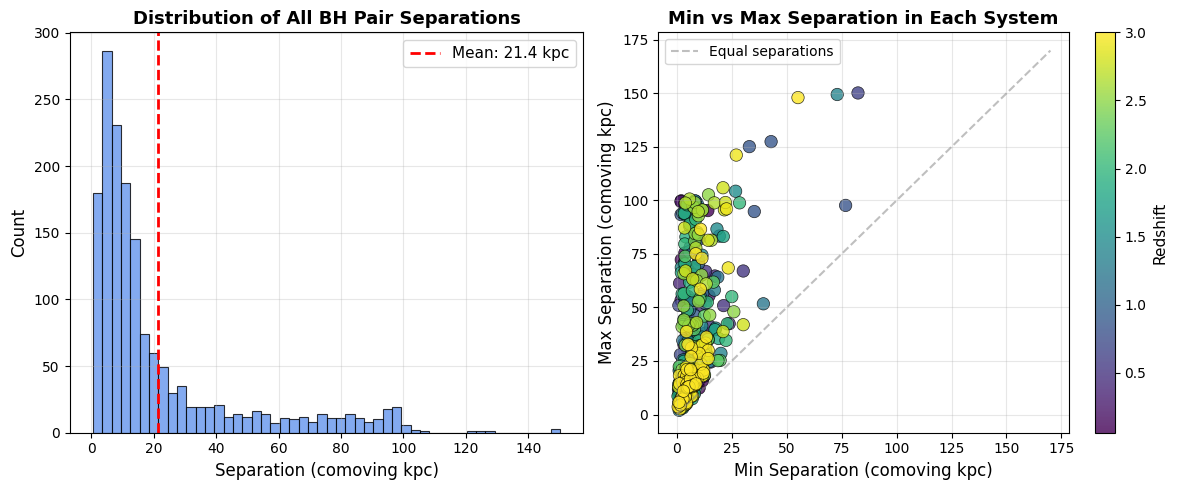

Comoving plot saved to: /home/stlock/tripleAGN/plots_and_data/triple_agn_separations_comoving.png
Separation data saved to: /home/stlock/tripleAGN/plots_and_data/triple_agn_separation_data.csv

ANALYSIS COMPLETE


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.gridspec import GridSpec

# Define paths
catalog_path = "/scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_100kpc_1e40lum/"
#catalog_path = "/scratch/stlock/tripleAGNs/catalogs/proper_kpc/1e43lum/catalogue_30kpc_1e43lum/"
output_dir = "/home/stlock/tripleAGN/plots_and_data/"
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("ANALYZING TRIPLE AGN SEPARATIONS")
print("="*70)

# Search for catalog files
files_pkl = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.pkl"))
files_csv = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.csv"))
files_h5 = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.h5"))

# Prefer pickle files, then CSV, then HDF5
if files_pkl:
    files_to_read = files_pkl
    file_format = 'pkl'
elif files_csv:
    files_to_read = files_csv
    file_format = 'csv'
elif files_h5:
    files_to_read = files_h5
    file_format = 'h5'
else:
    print("No catalog files found!")
    exit(1)

print(f"Found {len(files_to_read)} catalog files ({file_format} format)\n")

# Storage for all systems
all_systems = []

# Read each file
for file_path in files_to_read:
    try:
        # Read the file based on format
        if file_format == 'pkl':
            df = pd.read_pickle(file_path)
        elif file_format == 'csv':
            df = pd.read_csv(file_path)
        elif file_format == 'h5':
            df = pd.read_hdf(file_path, key='tripleagn')
        
        if len(df) == 0:
            continue
        
        # Extract redshift from filename (format: TripleAGN-Catalog-R50-z{z}.pkl)
        filename = os.path.basename(file_path)
        z_str = filename.split('-z')[1].split('.pkl')[0].split('.csv')[0].split('.h5')[0]
        z = float(z_str)
        
        # Scale factor for converting comoving -> physical
        a = 1.0 / (1.0 + z)
        
        # Extract separation data for each system (stored as comoving, convert to physical)
        for idx, row in df.iterrows():
            sep_12_com = row.get('Separation_3D_1_kpc_com', np.nan)
            sep_13_com = row.get('Separation_3D_2_kpc_com', np.nan)
            sep_23_com = row.get('Separation_3D_12_kpc_com', np.nan)
            
            # Convert to physical kpc
            sep_12_phys = sep_12_com * a
            sep_13_phys = sep_13_com * a
            sep_23_phys = sep_23_com * a
            
            system_data = {
                'redshift': z,
                'scale_factor': a,
                'system_id': idx,
                # Store both comoving and physical
                'sep_BH1_BH2_com': sep_12_com,
                'sep_BH1_BH3_com': sep_13_com,
                'sep_BH2_BH3_com': sep_23_com,
                'sep_BH1_BH2': sep_12_phys,
                'sep_BH1_BH3': sep_13_phys,
                'sep_BH2_BH3': sep_23_phys,
                'min_separation': np.nanmin([sep_12_phys, sep_13_phys, sep_23_phys]),
                'max_separation': np.nanmax([sep_12_phys, sep_13_phys, sep_23_phys]),
                'mean_separation': np.nanmean([sep_12_phys, sep_13_phys, sep_23_phys]),
                'separation_ratio': np.nanmax([sep_12_phys, sep_13_phys, sep_23_phys]) / np.nanmin([sep_12_phys, sep_13_phys, sep_23_phys]),
                
                # Also store comoving statistics for reference
                'min_separation_com': np.nanmin([sep_12_com, sep_13_com, sep_23_com]),
                'max_separation_com': np.nanmax([sep_12_com, sep_13_com, sep_23_com]),
                
                # BH masses for context
                'BH1_mass': row.get('BH_mass', np.nan),
                'BH2_mass': row.get('Neighbour1BH_mass', np.nan),
                'BH3_mass': row.get('Neighbour2BH_mass', np.nan),
                
                # BH luminosities
                'BH1_Lbol': row.get('BH_Lbol', np.nan),
                'BH2_Lbol': row.get('Neighbour1BH_Lbol', np.nan),
                'BH3_Lbol': row.get('Neighbour2BH_Lbol', np.nan),
                
                # BH IDs for tracking
                'BH1_id': row.get('BH_id', np.nan),
                'BH2_id': row.get('Neighbour1BH_id', np.nan),
                'BH3_id': row.get('Neighbour2BH_id', np.nan),
                
                # Halo info
                'halo_id': row.get('pynbody_haloid', np.nan),
                'halo_mass': row.get('Halo_Mvir', np.nan),
            }
            
            all_systems.append(system_data)
        
        print(f"z={z:.2f}: {len(df)} system(s)")
        
    except Exception as e:
        print(f"ERROR reading {os.path.basename(file_path)}: {e}")
        continue

if len(all_systems) == 0:
    print("No triple AGN systems found!")
    exit(0)

# Convert to DataFrame
systems_df = pd.DataFrame(all_systems)

print(f"\nTotal systems analyzed: {len(systems_df)}")

# Print statistics (in physical kpc)
print("\n" + "="*70)
print("SEPARATION STATISTICS (Physical kpc)")
print("="*70)
print(f"\nMinimum separations (closest BH pair in each system):")
print(f"  Range: {systems_df['min_separation'].min():.2f} - {systems_df['min_separation'].max():.2f} kpc")
print(f"  Mean: {systems_df['min_separation'].mean():.2f} ± {systems_df['min_separation'].std():.2f} kpc")
print(f"  Median: {systems_df['min_separation'].median():.2f} kpc")

print(f"\nMaximum separations (farthest BH pair in each system):")
print(f"  Range: {systems_df['max_separation'].min():.2f} - {systems_df['max_separation'].max():.2f} kpc")
print(f"  Mean: {systems_df['max_separation'].mean():.2f} ± {systems_df['max_separation'].std():.2f} kpc")
print(f"  Median: {systems_df['max_separation'].median():.2f} kpc")

print(f"\nSeparation ratio (max/min in each system):")
print(f"  Range: {systems_df['separation_ratio'].min():.2f} - {systems_df['separation_ratio'].max():.2f}")
print(f"  Mean: {systems_df['separation_ratio'].mean():.2f} ± {systems_df['separation_ratio'].std():.2f}")
print(f"  Median: {systems_df['separation_ratio'].median():.2f}")

# Identify compact vs extended systems
compact_systems = systems_df[systems_df['max_separation'] < 20]
extended_systems = systems_df[systems_df['max_separation'] > 30]
print(f"\nCompact systems (max sep < 20 kpc): {len(compact_systems)} ({100*len(compact_systems)/len(systems_df):.1f}%)")
print(f"Extended systems (max sep > 30 kpc): {len(extended_systems)} ({100*len(extended_systems)/len(systems_df):.1f}%)")

# Determine dynamic axis limits based on data
all_seps = np.concatenate([systems_df['sep_BH1_BH2'].dropna(), 
                           systems_df['sep_BH1_BH3'].dropna(), 
                           systems_df['sep_BH2_BH3'].dropna()])

all_seps_com = np.concatenate([systems_df['sep_BH1_BH2_com'].dropna(), 
                               systems_df['sep_BH1_BH3_com'].dropna(), 
                               systems_df['sep_BH2_BH3_com'].dropna()])

# Calculate nice round limits with some padding
hist_max_phys = np.ceil(np.percentile(all_seps, 99) / 10) * 10  # Round to nearest 10
hist_max_com = np.ceil(np.percentile(all_seps_com, 99) / 10) * 10

scatter_max_phys = np.ceil(systems_df['max_separation'].max() / 10) * 10 + 10  # Add padding
scatter_max_com = np.ceil(systems_df['max_separation_com'].max() / 10) * 10 + 10

print(f"\nPlot limits:")
print(f"  Physical histogram: 0-{hist_max_phys:.0f} kpc")
print(f"  Physical scatter: 0-{scatter_max_phys:.0f} kpc")
print(f"  Comoving histogram: 0-{hist_max_com:.0f} kpc")
print(f"  Comoving scatter: 0-{scatter_max_com:.0f} kpc")

# Create visualization matching the provided plots (using physical kpc)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Distribution of all separations (PHYSICAL kpc)
n_bins = int(hist_max_phys / 2)  # 2 kpc bins
ax1.hist(all_seps, bins=n_bins, color='cornflowerblue', alpha=0.8, edgecolor='black', linewidth=0.8)
ax1.axvline(all_seps.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_seps.mean():.1f} kpc')
ax1.set_xlabel('Separation (physical kpc)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of All BH Pair Separations', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
##ax1.set_xlim(0, hist_max_phys)

# Plot 2: Min vs Max separation (PHYSICAL kpc)
scatter = ax2.scatter(systems_df['min_separation'], systems_df['max_separation'], 
                     c=systems_df['redshift'], cmap='viridis', s=80, alpha=0.8, 
                     edgecolor='black', linewidth=0.5)
ax2.plot([0, scatter_max_phys], [0, scatter_max_phys], color='gray', linestyle='--', alpha=0.5, linewidth=1.5, label='Equal separations')
ax2.set_xlabel('Min Separation (physical kpc)', fontsize=12)
ax2.set_ylabel('Max Separation (physical kpc)', fontsize=12)
ax2.set_title('Min vs Max Separation in Each System', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
##ax1.set_xlim(0, scatter_max_phys)
##ax1.set_xlim(0, scatter_max_phys)
cbar = plt.colorbar(scatter, ax=ax2, label='Redshift')
cbar.set_label('Redshift', fontsize=11)

plt.tight_layout()

plot_path = os.path.join(output_dir, "triple_agn_separations_physical.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {plot_path}")
plt.close()

# Also create comoving version for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Distribution of all separations (COMOVING kpc)
n_bins_com = int(hist_max_com / 2)  # 2 kpc bins
ax1.hist(all_seps_com, bins=n_bins_com,  color='cornflowerblue', alpha=0.8, edgecolor='black', linewidth=0.8)
ax1.axvline(all_seps_com.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_seps_com.mean():.1f} kpc')
ax1.set_xlabel('Separation (comoving kpc)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of All BH Pair Separations', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
##ax1.set_xlim(0, hist_max_com)

# Plot 2: Min vs Max separation (COMOVING kpc)
scatter = ax2.scatter(systems_df['min_separation_com'], systems_df['max_separation_com'], 
                     c=systems_df['redshift'], cmap='viridis', s=80, alpha=0.8, 
                     edgecolor='black', linewidth=0.5)
ax2.plot([0, scatter_max_com], [0, scatter_max_com], color='gray', linestyle='--', alpha=0.5, linewidth=1.5, label='Equal separations')
ax2.set_xlabel('Min Separation (comoving kpc)', fontsize=12)
ax2.set_ylabel('Max Separation (comoving kpc)', fontsize=12)
ax2.set_title('Min vs Max Separation in Each System', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
##ax1.set_xlim(0, scatter_max_com)
##ax1.set_xlim(0, scatter_max_com)
cbar = plt.colorbar(scatter, ax=ax2, label='Redshift')
cbar.set_label('Redshift', fontsize=11)

plt.tight_layout()
plt.show()

plot_path_com = os.path.join(output_dir, "triple_agn_separations_comoving.png")
plt.savefig(plot_path_com, dpi=300, bbox_inches='tight')
print(f"Comoving plot saved to: {plot_path_com}")
plt.close()

# Save detailed data
data_path = os.path.join(output_dir, "triple_agn_separation_data.csv")
systems_df.to_csv(data_path, index=False)
print(f"Separation data saved to: {data_path}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)